# <center>Part 2 - House prices</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import *
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, validation_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import *
from sklearn.decomposition import *
from multiprocessing import Pool
from sklearn.base import clone
sns.set()
%matplotlib inline

def data_info(X, iqrfact=1.5, zlim=3):
    data_nulls = X.isnull().agg(['mean','sum'], axis=0).set_index(pd.Index(['PercentageOfNullValues', 'NumberOfNullValues'])).T
    data_nulls['NumberOfNonNullValues']=X.shape[0]-data_nulls.NumberOfNullValues
    data_nulls['PercentageOfNullValues'] = 100*data_nulls['PercentageOfNullValues']
    Q1 =  X.quantile(0.25).rename('q1')
    Q3 = X.quantile(0.75).rename('q3')
    IQR = (Q3 - Q1).rename('iqr')
    M1 = (Q1 - iqrfact*IQR).rename('min_whisker')
    M2 = (Q3 + iqrfact*IQR).rename('max_whisker')
    N = ((X<M1) | (X>M2)).sum(axis=0).rename('iqr_outliers')
    Z = ( np.abs((X - X.mean())/X.std()) > zlim ).sum(axis=0).rename('zscore_outliers')
    return pd.concat([data_nulls, X.describe().loc[['min','max'], :].T.astype(int), Q1, Q3, IQR, M1, M2, N, Z], axis=1)

def data_scatter(X, col, ncols=4,zlim=3, figsize=(20,20),hue='hue', method=sns.scatterplot):
    x_cols = X.columns.difference([col])
    nlines = 1+(len(x_cols)//ncols)
    fig, axes = plt.subplots(nrows=nlines, ncols=ncols, figsize=figsize)
    for i, xcol in enumerate(x_cols):
        Y = X[[xcol,col]].copy()
        Y['hue'] = ( np.abs((X - X.mean())/X.std()) > zlim)[xcol]
        method(data=Y, x=xcol, y=col, ax=axes[i//ncols,i%ncols], hue=hue)
        
categorical=['MS SubClass','MS Zoning','Street','Alley','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type',
             'House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air',
             'Garage Type','Misc Feature','Sale Type','Sale Condition']
ordinal=['Lot Shape','Land Slope','Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond',
         'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Kitchen Qual','Functional','Fireplace Qu','Garage Finish',
         'Garage Qual','Garage Cond','Paved Drive','Fence','Electrical',
        'Pool QC','Utilities']
discrete=['Year Built','Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Yr Blt',
          'Garage Cars','Mo Sold','Yr Sold']
numeric = ['1st Flr SF', '2nd Flr SF', 'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Enclosed Porch', 'Garage Area', 'Gr Liv Area', 'Lot Area',
           'Lot Frontage',  'Mas Vnr Area', 'Open Porch SF',  'SalePrice', 'Screen Porch', 'Total Bsmt SF', 'Wood Deck SF', 
           'Low Qual Fin SF','Misc Val', 'Pool Area','3Ssn Porch']

all = categorical+ordinal+discrete+numeric

Loading test and train datasets and defining all numeric columns types as float

In [2]:
data = pd.read_csv('house-prices.csv').drop(['Order'], axis=1)
test = pd.read_csv('house-prices-test.csv').drop(['Order'], axis=1)
for col in data.select_dtypes('int64').columns.intersection(numeric):
   data[col] = data[col].astype(np.float64)
for col in test.select_dtypes('int64').columns.intersection(numeric):
   test[col] = test[col].astype(np.float64)

In [3]:
data.head()

PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  528275070           60        RL           NaN    8795.0   Pave   NaN   
1  535305120           20        RL          75.0   10170.0   Pave   NaN   
2  923228250          160        RM          21.0    2001.0   Pave   NaN   
3  535152150           20        RL          70.0   10552.0   Pave   NaN   
4  903475060          190        RM          60.0   10120.0   Pave   NaN   

  Lot Shape Land Contour Utilities  ... Pool Area Pool QC  Fence Misc Feature  \
0       IR1          Lvl    AllPub  ...       0.0     NaN    NaN          NaN   
1       Reg          Lvl    AllPub  ...       0.0     NaN    NaN          NaN   
2       Reg          Lvl    AllPub  ...       0.0     NaN    NaN          NaN   
3       IR1          Lvl    AllPub  ...       0.0     NaN    NaN          NaN   
4       IR1          Bnk    AllPub  ...       0.0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold  Sale Type  Sale Condition  SalePrice  
0      0.0       4    2009        WD           Normal   236000.0  
1      0.0       6    2006        WD           Normal   155000.0  
2      0.0       1    2007        WD           Normal    75000.0  
3      0.0       4    2010        WD           Normal   165500.0  
4      0.0       1    2007        WD           Normal   122000.0  

[5 rows x 81 columns]

In [4]:
data.shape

(2430, 81)

In [5]:
test.head()

PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  909279080           50        RL           NaN   11275.0   Pave   NaN   
1  907126050           20        RL          65.0    9757.0   Pave   NaN   
2  528144030           60        RL          86.0   11065.0   Pave   NaN   
3  535452060           20        RL          70.0    7000.0   Pave   NaN   
4  911202100           50   C (all)          66.0    8712.0   Pave  Pave   

  Lot Shape Land Contour Utilities  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          HLS    AllPub  ...          0.0       0.0     NaN   NaN   
1       Reg          Low    AllPub  ...         92.0       0.0     NaN   NaN   
2       IR1          Lvl    AllPub  ...          0.0       0.0     NaN   NaN   
3       Reg          Lvl    AllPub  ...          0.0       0.0     NaN  MnWw   
4       Reg          HLS    AllPub  ...          0.0       0.0     NaN   NaN   

  Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  Sale Condition  
0          NaN      0.0       3     2007        WD           Normal  
1          NaN      0.0      10     2009        WD           Normal  
2          NaN      0.0      10     2006        New         Partial  
3          NaN      0.0       4     2007        WD           Family  
4          NaN      0.0       1     2010        WD          Abnorml  

[5 rows x 80 columns]

In [6]:
test.shape

(500, 80)

## Data cleaning
Your analysis should include the necessary data cleaning steps. For instance
- Find and handle incorrect, missing values
- Correct inconsistencies in the variables
- Handle outliers

For discrete data :

In [7]:
data_info(data[discrete])

PercentageOfNullValues  NumberOfNullValues  \
Year Built                    0.000000                 0.0   
Year Remod/Add                0.000000                 0.0   
Bsmt Full Bath                0.082305                 2.0   
Bsmt Half Bath                0.082305                 2.0   
Full Bath                     0.000000                 0.0   
Half Bath                     0.000000                 0.0   
Bedroom AbvGr                 0.000000                 0.0   
Kitchen AbvGr                 0.000000                 0.0   
TotRms AbvGrd                 0.000000                 0.0   
Fireplaces                    0.000000                 0.0   
Garage Yr Blt                 5.679012               138.0   
Garage Cars                   0.041152                 1.0   
Mo Sold                       0.000000                 0.0   
Yr Sold                       0.000000                 0.0   

                NumberOfNonNullValues   min   max      q1      q3   iqr  \
Year Built                     2430.0  1875  2010  1954.0  2000.0  46.0   
Year Remod/Add                 2430.0  1950  2010  1966.0  2003.0  37.0   
Bsmt Full Bath                 2428.0     0     3     0.0     1.0   1.0   
Bsmt Half Bath                 2428.0     0     2     0.0     0.0   0.0   
Full Bath                      2430.0     0     4     1.0     2.0   1.0   
Half Bath                      2430.0     0     2     0.0     1.0   1.0   
Bedroom AbvGr                  2430.0     0     8     2.0     3.0   1.0   
Kitchen AbvGr                  2430.0     0     3     1.0     1.0   0.0   
TotRms AbvGrd                  2430.0     2    15     5.0     7.0   2.0   
Fireplaces                     2430.0     0     4     0.0     1.0   1.0   
Garage Yr Blt                  2292.0  1896  2207  1960.0  2002.0  42.0   
Garage Cars                    2429.0     0     4     1.0     2.0   1.0   
Mo Sold                        2430.0     1    12     4.0     8.0   4.0   
Yr Sold                        2430.0  2006  2010  2007.0  2009.0   2.0   

                min_whisker  max_whisker  iqr_outliers  zscore_outliers  
Year Built           1885.0       2069.0             6                6  
Year Remod/Add       1910.5       2058.5             0                0  
Bsmt Full Bath         -1.5          2.5             2                2  
Bsmt Half Bath          0.0          0.0           143              143  
Full Bath              -0.5          3.5             3                3  
Half Bath              -1.5          2.5             0               22  
Bedroom AbvGr           0.5          4.5            61               21  
Kitchen AbvGr           1.0          1.0           107              107  
TotRms AbvGrd           2.0         10.0            36               14  
Fireplaces             -1.5          2.5            11               11  
Garage Yr Blt        1897.0       2065.0             2                7  
Garage Cars            -0.5          3.5            12                0  
Mo Sold                -2.0         14.0             0                0  
Yr Sold              2004.0       2012.0             0                0

- Garage Yr Blt : some data iswrong (year > 2010). Will remove years > 2010.
- Min and max values seems correct. No aberant values for other columns.

For numeric data :

In [8]:
data_info(data[numeric],10,5)

PercentageOfNullValues  NumberOfNullValues  \
1st Flr SF                     0.000000                 0.0   
2nd Flr SF                     0.000000                 0.0   
Bsmt Unf SF                    0.041152                 1.0   
BsmtFin SF 1                   0.041152                 1.0   
BsmtFin SF 2                   0.041152                 1.0   
Enclosed Porch                 0.000000                 0.0   
Garage Area                    0.041152                 1.0   
Gr Liv Area                    0.000000                 0.0   
Lot Area                       0.000000                 0.0   
Lot Frontage                  17.283951               420.0   
Mas Vnr Area                   0.823045                20.0   
Open Porch SF                  0.000000                 0.0   
SalePrice                      0.000000                 0.0   
Screen Porch                   0.000000                 0.0   
Total Bsmt SF                  0.041152                 1.0   
Wood Deck SF                   0.000000                 0.0   
Low Qual Fin SF                0.000000                 0.0   
Misc Val                       0.000000                 0.0   
Pool Area                      0.000000                 0.0   
3Ssn Porch                     0.000000                 0.0   

                 NumberOfNonNullValues    min     max        q1         q3  \
1st Flr SF                      2430.0    334    5095     880.5    1387.75   
2nd Flr SF                      2430.0      0    2065       0.0     698.00   
Bsmt Unf SF                     2429.0      0    2336     216.0     799.00   
BsmtFin SF 1                    2429.0      0    5644       0.0     737.00   
BsmtFin SF 2                    2429.0      0    1526       0.0       0.00   
Enclosed Porch                  2430.0      0    1012       0.0       0.00   
Garage Area                     2429.0      0    1488     324.0     576.00   
Gr Liv Area                     2430.0    334    5642    1120.0    1740.00   
Lot Area                        2430.0   1470  215245    7482.0   11604.50   
Lot Frontage                    2010.0     21     313      58.0      80.00   
Mas Vnr Area                    2410.0      0    1600       0.0     164.75   
Open Porch SF                   2430.0      0     742       0.0      70.00   
SalePrice                       2430.0  12789  755000  129000.0  213099.75   
Screen Porch                    2430.0      0     490       0.0       0.00   
Total Bsmt SF                   2429.0      0    6110     794.0    1299.00   
Wood Deck SF                    2430.0      0    1424       0.0     168.00   
Low Qual Fin SF                 2430.0      0    1064       0.0       0.00   
Misc Val                        2430.0      0   17000       0.0       0.00   
Pool Area                       2430.0      0     800       0.0       0.00   
3Ssn Porch                      2430.0      0     508       0.0       0.00   

                      iqr  min_whisker  max_whisker  iqr_outliers  \
1st Flr SF         507.25      -4192.0      6460.25             0   
2nd Flr SF         698.00      -6980.0      7678.00             0   
Bsmt Unf SF        583.00      -5614.0      6629.00             0   
BsmtFin SF 1       737.00      -7370.0      8107.00             0   
BsmtFin SF 2         0.00          0.0         0.00           294   
Enclosed Porch       0.00          0.0         0.00           375   
Garage Area        252.00      -2196.0      3096.00             0   
Gr Liv Area        620.00      -5080.0      7940.00             0   
Lot Area          4122.50     -33743.0     52829.50            10   
Lot Frontage        22.00       -162.0       300.00             2   
Mas Vnr Area       164.75      -1647.5      1812.25             0   
Open Porch SF       70.00       -700.0       770.00             0   
SalePrice        84099.75    -711997.5   1054097.25             0   
Screen Porch         0.00          0.0         0.00           218   
Total Bsmt SF      

We will verify if data has normal distribution by plotting the histograms :

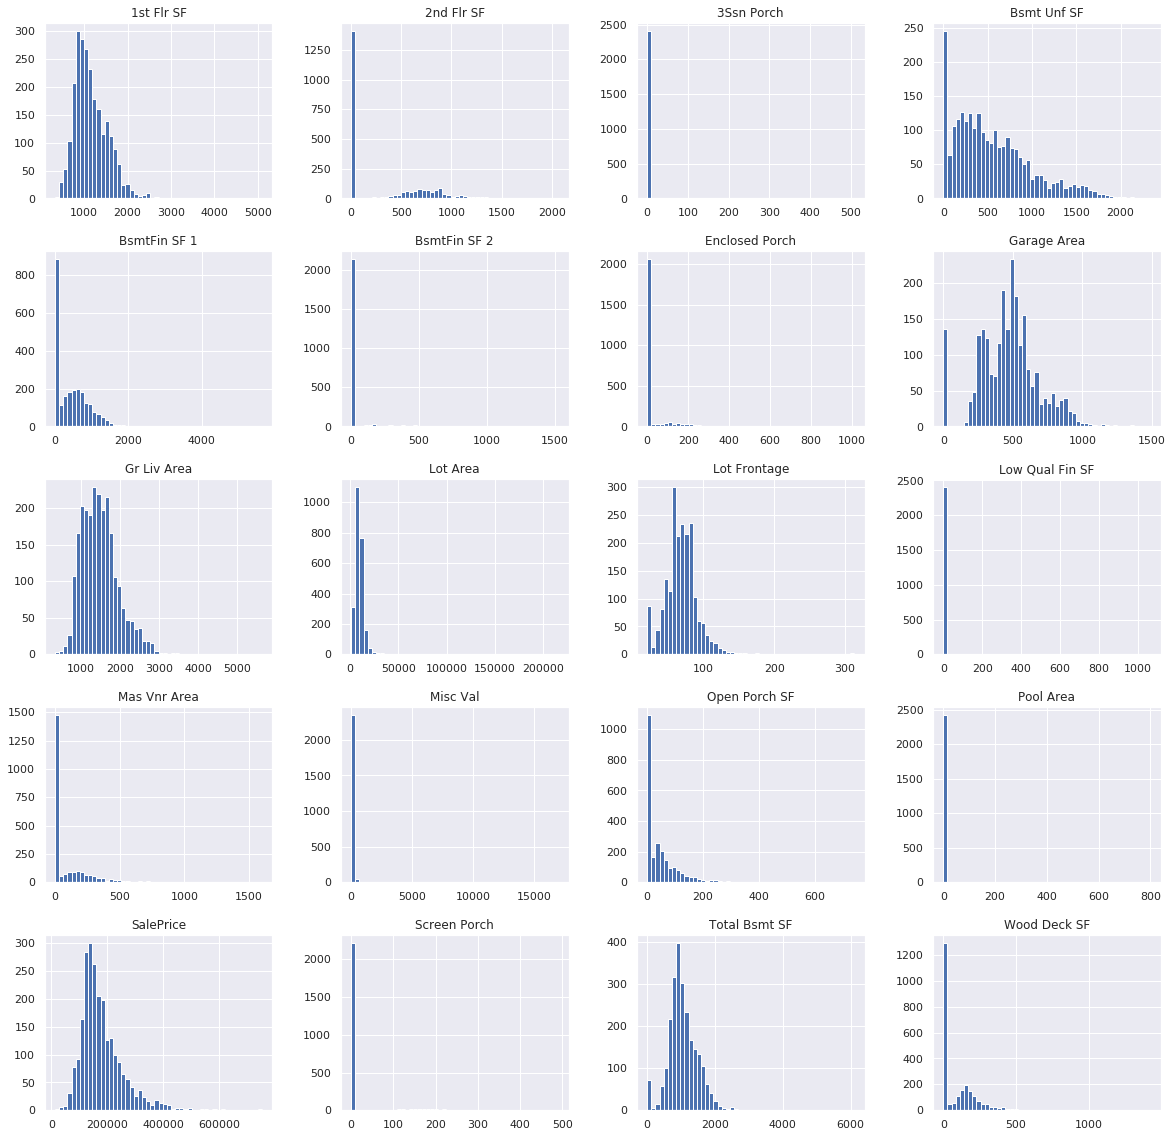

In [9]:
data[numeric].hist(figsize=(20,20),bins=50);

most columns doesn't have normal distribution. Zscore and IQR outlier detection method us useless.

We will display data to identify outliers :

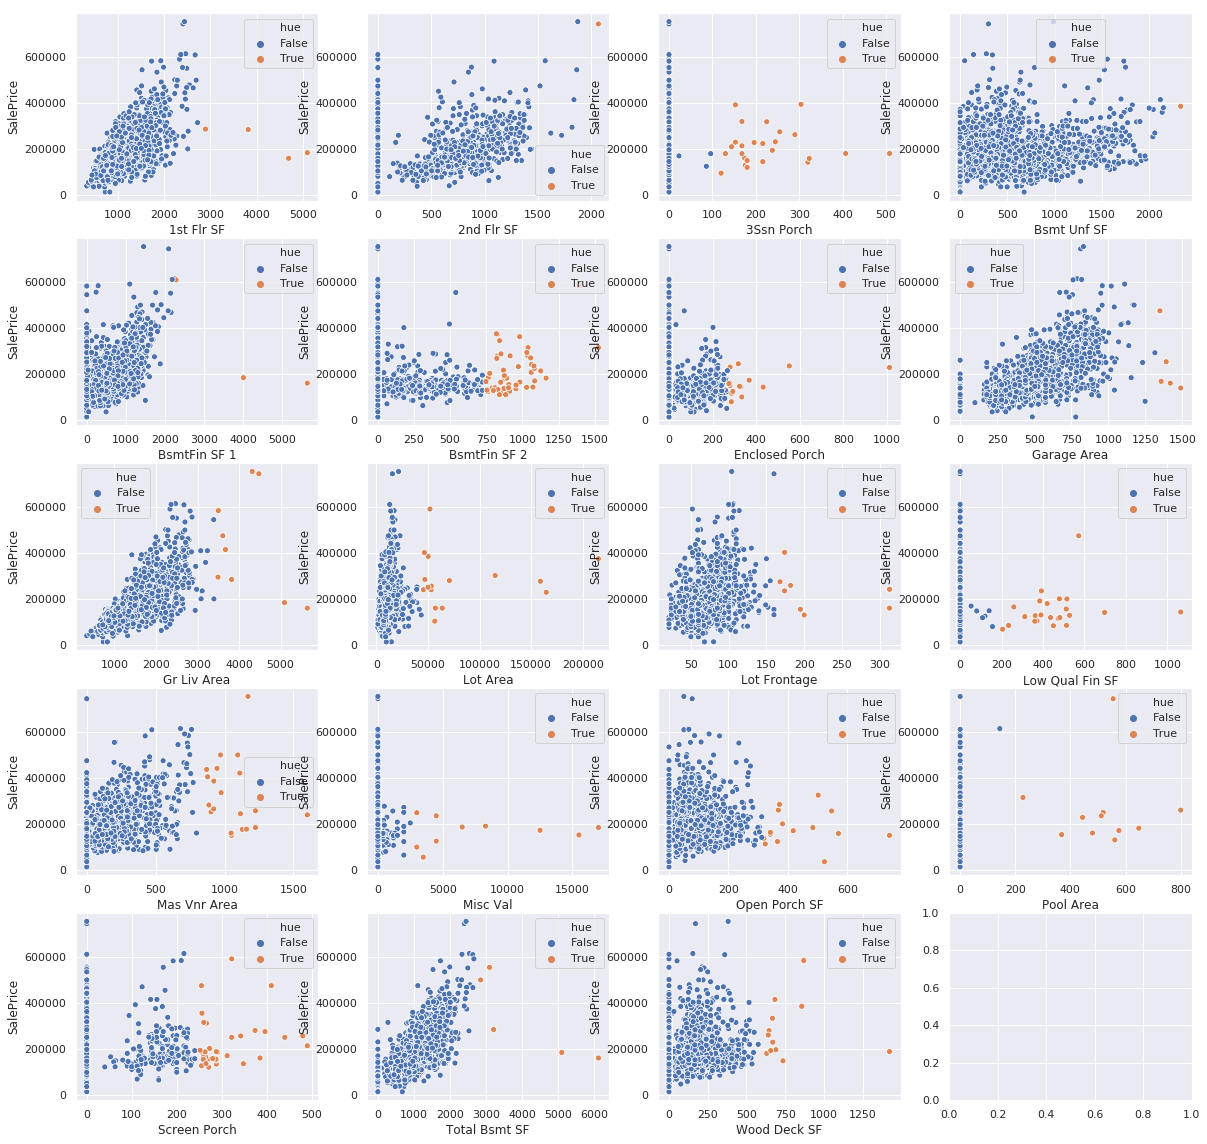

In [10]:
data_scatter(data[numeric], 'SalePrice',zlim=4, ncols=4, figsize=(20,20))

There is some outliers. We will remove them manually.

In [11]:
outliers_limits = {
  '1st Flr SF': 2400,
  '2nd Flr SF': 1500,
    'Bsmt Unf SF':2000,
 'BsmtFin SF 1': 1500,
 'BsmtFin SF 2': 1300,
 '3Ssn Porch':400,
 'Lot Area':23000,
    'Garage Area':1000,
 'Open Porch SF':250,
 'Screen Porch':250,
 'Enclosed Porch': 500,
 'Gr Liv Area': 3000,
 'Lot Frontage': 140,
 'Low Qual Fin SF': 600,
 'Mas Vnr Area': 600,
 'Misc Val': 10000,
 'Total Bsmt SF': 4000,
 'Wood Deck SF': 1000,
 'Total Bsmt SF':3000,
 'Wood Deck SF':600,
 'SalePrice':500000,
'Bsmt Full Bath':2.5,
 'Bsmt Half Bath':1.5,
 'Full Bath':3.5,
 'Kitchen AbvGr':2.5,
 'Garage Yr Blt':2020,
 'Garage Cars':3.5
}
data.drop(data[(data[outliers_limits.keys()] > list(outliers_limits.values())).any(axis=1)].index, inplace=True)

Some columns contains only one value which reprensents more than 90% of data, or null reprensents more than 90% of values :

In [12]:
for col in ['Low Qual Fin SF','Misc Val', 'Pool Area','3Ssn Porch', 'Pool QC','Utilities', 'Alley', 'Fence', 'Street']:
    print ('column :', col)
    print(data[col].fillna(0).value_counts())

column : Low Qual Fin SF
0.0      2149
80.0        2
420.0       1
120.0       1
512.0       1
53.0        1
384.0       1
108.0       1
360.0       1
450.0       1
513.0       1
436.0       1
259.0       1
390.0       1
473.0       1
140.0       1
234.0       1
312.0       1
528.0       1
156.0       1
481.0       1
362.0       1
371.0       1
205.0       1
Name: Low Qual Fin SF, dtype: int64
column : Misc Val
0.0       2101
400.0       14
500.0        9
600.0        7
450.0        7
2000.0       5
700.0        4
650.0        3
1200.0       3
1500.0       3
3000.0       2
4500.0       2
350.0        1
420.0        1
300.0        1
8300.0       1
2500.0       1
1300.0       1
3500.0       1
800.0        1
460.0        1
80.0         1
480.0        1
1000.0       1
620.0        1
Name: Misc Val, dtype: int64
column : Pool Area
0.0      2170
648.0       1
368.0       1
576.0       1
Name: Pool Area, dtype: int64
column : 3Ssn Porch
0.0      2148
168.0       3
180.0       2
144.0       2


We will drop these columns inf tranformData because they are useless.

In [13]:
ordinal=['Lot Shape','Land Slope','Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond',
         'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Kitchen Qual','Functional','Fireplace Qu','Garage Finish',
         'Garage Qual','Garage Cond','Paved Drive','Electrical']
numeric = ['1st Flr SF', '2nd Flr SF', 'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Enclosed Porch', 'Garage Area', 'Gr Liv Area', 'Lot Area',
           'Lot Frontage',  'Mas Vnr Area', 'Open Porch SF',  'SalePrice', 'Screen Porch', 'Total Bsmt SF', 'Wood Deck SF']
categorical=['MS SubClass','MS Zoning','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type',
             'House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air',
             'Garage Type','Misc Feature','Sale Type','Sale Condition']

In [14]:
data.shape

(2173, 81)

for discrete columns :


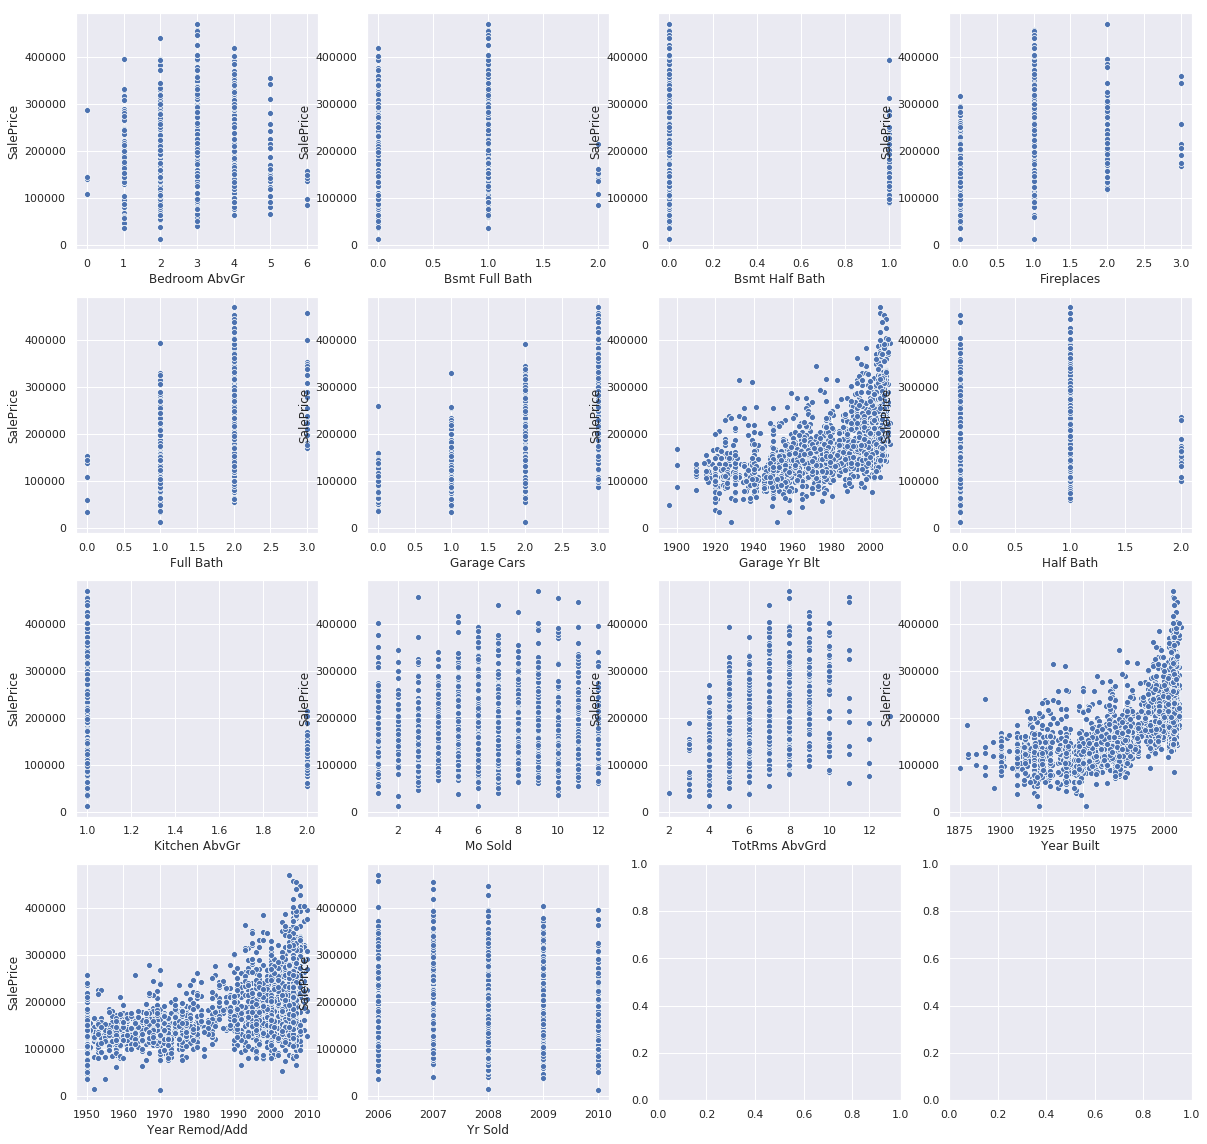

In [15]:
data_scatter(data[discrete+['SalePrice']], 'SalePrice',zlim=50, ncols=4, figsize=(20,20),hue=None)

for the columns, data seems to be correct.

For ordinal data :

These columns are not encoded consistently. We have to transform them before looking for outliers. We will transform all categorical and ordinal data to numeric values.

To do so, a dictionay variable (data_dic) will contains, for each colums, a mapping between old values and new values. The function transformData will be used to replace values.

For ordinal columns, null values are replaced by 0, and order is from worse(value 1) to best( value > 1)

In [16]:
data_dic =  {
            # Categorical variables 
            'MS SubClass':{20:0, 30:1, 40:2, 45 :3, 50:4, 60:5, 70:6, 75:7, 80:8, 85:9, 90:10, 120:11, 150:12, 160:13, 180:14, 190:15},
            'MS Zoning':{'A (agr)':0,'C (all)':1,'FV':2,'I (all)':3,'RH':4,'RL':5,'RM':6,'RP':7},
            'Street':{'Grvl':0,'Pave':1},
            'Alley':{'Grvl':0,'Pave':1,np.nan:2},
            'Land Contour':{'Bnk':0,'HLS':1,'Low':2,'Lvl':3},
            'Lot Config':{'Corner':0,'CulDSac':1,'FR2':2,'FR3':3,'Inside':4},
            'Neighborhood':{'Blmngtn':0,'Blueste':1,'BrDale':2,'BrkSide':3,'ClearCr':4,'CollgCr':5,'Crawfor':6,'Edwards':7,'Gilbert':8,'Greens':9,'GrnHill':10,'IDOTRR':11,'Landmrk':12,'MeadowV':13,'Mitchel':14,'NAmes':15,'NPkVill':16,'NWAmes':17,'NoRidge':18,'NridgHt':19,'OldTown':20,'SWISU':21,'Sawyer':22,'SawyerW':23,'Somerst':24,'StoneBr':25,'Timber':26,'Veenker':27},
            'Condition 1':{'Artery':0,'Feedr':1,'Norm':2,'PosA':3,'PosN':4,'RRAe':5,'RRAn':6,'RRNe':7,'RRNn':8},
            'Condition 2':{'Artery':0,'Feedr':1,'Norm':2,'PosA':3,'PosN':4,'RRAe':5,'RRAn':6,'RRNe':7,'RRNn':8},
            'Bldg Type':{'1Fam':0,'2fmCon':1,'Duplex':2,'Duplx':2,'Twnhs':3,'TwnhsI':3,'TwnhsE':4},
            'House Style':{'1.5Fin':0,'1.5Unf':1,'1Story':2,'2.5Fin':3,'2.5Unf':4,'2Story':5,'SFoyer':6,'SLvl':7},
            'Roof Style':{'Flat':0,'Gable':1,'Gambrel':2,'Hip':3,'Mansard':4,'Shed':5},
            'Roof Matl':{'ClyTile':0,'CompShg':1,'Membran':2,'Metal':3,'Tar&Grv':4,'WdShake':5,'WdShngl':6,'Roll':7},
            'Exterior 1st':{'AsbShng':0,'AsphShn':1,'BrkComm':2,'BrkFace':3,'CBlock':4,'CemntBd':5,'HdBoard':6,'ImStucc':7,'MetalSd':8,'Plywood':9,'PreCast':10,'Stone':11,'Stucco':12,'VinylSd':13,'Wd Sdng':14,'WdShing':15,'Other':16},
            'Exterior 2nd':{'AsbShng':0,'AsphShn':1,'Brk Cmn':2,'BrkFace':3,'CBlock':4,'CmentBd':5,'HdBoard':6,'ImStucc':7,'MetalSd':8,'Plywood':9,'PreCast':10,'Stone':11,'Stucco':12,'VinylSd':13,'Wd Sdng':14,'Wd Shng':15,'Other':16},
            'Mas Vnr Type':{'BrkCmn':0,'BrkFace':1,'CBlock':2,'Stone':3,'None':4,np.nan:4},
            'Foundation':{'BrkTil':0,'CBlock':1,'PConc':2,'Slab':3,'Stone':4,'Wood':5},
            'Heating':{'Floor':0,'GasA':1,'GasW':2,'Grav':3,'OthW':4,'Wall':5},
            'Central Air':{'N':0,'Y':1},
            'Garage Type':{'2Types':0,'Attchd':1,'Basment':2,'BuiltIn':3,'CarPort':4,'Detchd':5,np.nan:6},
            'Misc Feature':{'Elev':0,'Gar2':1,'Othr':2,'Shed':3,'TenC':4,np.nan:5},
            'Sale Type':{'COD':0,'CWD':1,'Con':2,'ConLD':3,'ConLI':4,'ConLw':5,'New':6,'Oth':7,'VWD':8,'WD ':9},
            'Sale Condition':{'Abnorml':0,'AdjLand':1,'Alloca':2,'Family':3,'Normal':4,'Partial':5},
            # ordinal variables
            'Lot Shape':{'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4, np.nan: 0},
            'Utilities':{'ELO':1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4, np.nan: 0},
            'Land Slope':{'Sev': 1, 'Mod': 2, 'Gtl': 3, np.nan: 0},
            'Exter Qual':{'Po': 1, 'Fa': 2, 'TA': 3,  'Gd': 4, 'Ex': 5, np.nan: 0},
            'Exter Cond':{'Po': 1, 'Fa': 2, 'TA': 3,  'Gd': 4, 'Ex': 5, np.nan: 0},
            'Bsmt Qual':{'Po': 1, 'Fa': 2, 'TA': 3,  'Gd': 4, 'Ex': 5, np.nan: 0},
            'Bsmt Cond':{'Po': 1, 'Fa': 2, 'TA': 3,  'Gd': 4, 'Ex': 5, np.nan: 0},
            'Bsmt Exposure':{'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4, np.nan: 0},
            'BsmtFin Type 1':{'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6, np.nan: 0},
            'BsmtFin Type 2':{'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6, np.nan: 0},
            'Heating QC':{'Po': 1, 'Fa': 2, 'TA': 3,  'Gd': 4, 'Ex': 5, np.nan: 0},
            'Kitchen Qual':{'Po': 1, 'Fa': 2, 'TA': 3,  'Gd': 4, 'Ex': 5, np.nan: 0},
            'Electrical':{'FuseA':4,'FuseF':3,'FuseP':2,'Mix':1,'SBrkr':1, np.nan:0},
            'Functional':{'Maj1': 4, 'Maj2': 3, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Sal': 1, 'Sev': 2, 'Typ': 8, np.nan: 0},
            'Fireplace Qu':{'Po': 1, 'Fa': 2, 'TA': 3,  'Gd': 4, 'Ex': 5, np.nan: 0},
            'Garage Finish':{'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0},
            'Garage Qual':{'Po': 1, 'Fa': 2, 'TA': 3,  'Gd': 4, 'Ex': 5, np.nan: 0},
            'Garage Cond':{'Po': 1, 'Fa': 2, 'TA': 3,  'Gd': 4, 'Ex': 5, np.nan: 0},
            'Paved Drive':{'N': 1, 'P': 2, 'Y': 3, np.nan: 0},
            'Pool QC':{'Po': 1, 'Fa': 2, 'TA': 3,  'Gd': 4, 'Ex': 5, np.nan: 0},
            'Fence':{'GdPrv': 4, 'GdWo': 2, 'MnPrv': 3, 'MnWw': 1, np.nan: 0}
            }
def transformData(X):
    # replace values in ordinal and categorical features with new values from dic
    X_ = X.replace(data_dic)
    return X_

Let's display transformed ordinal data :

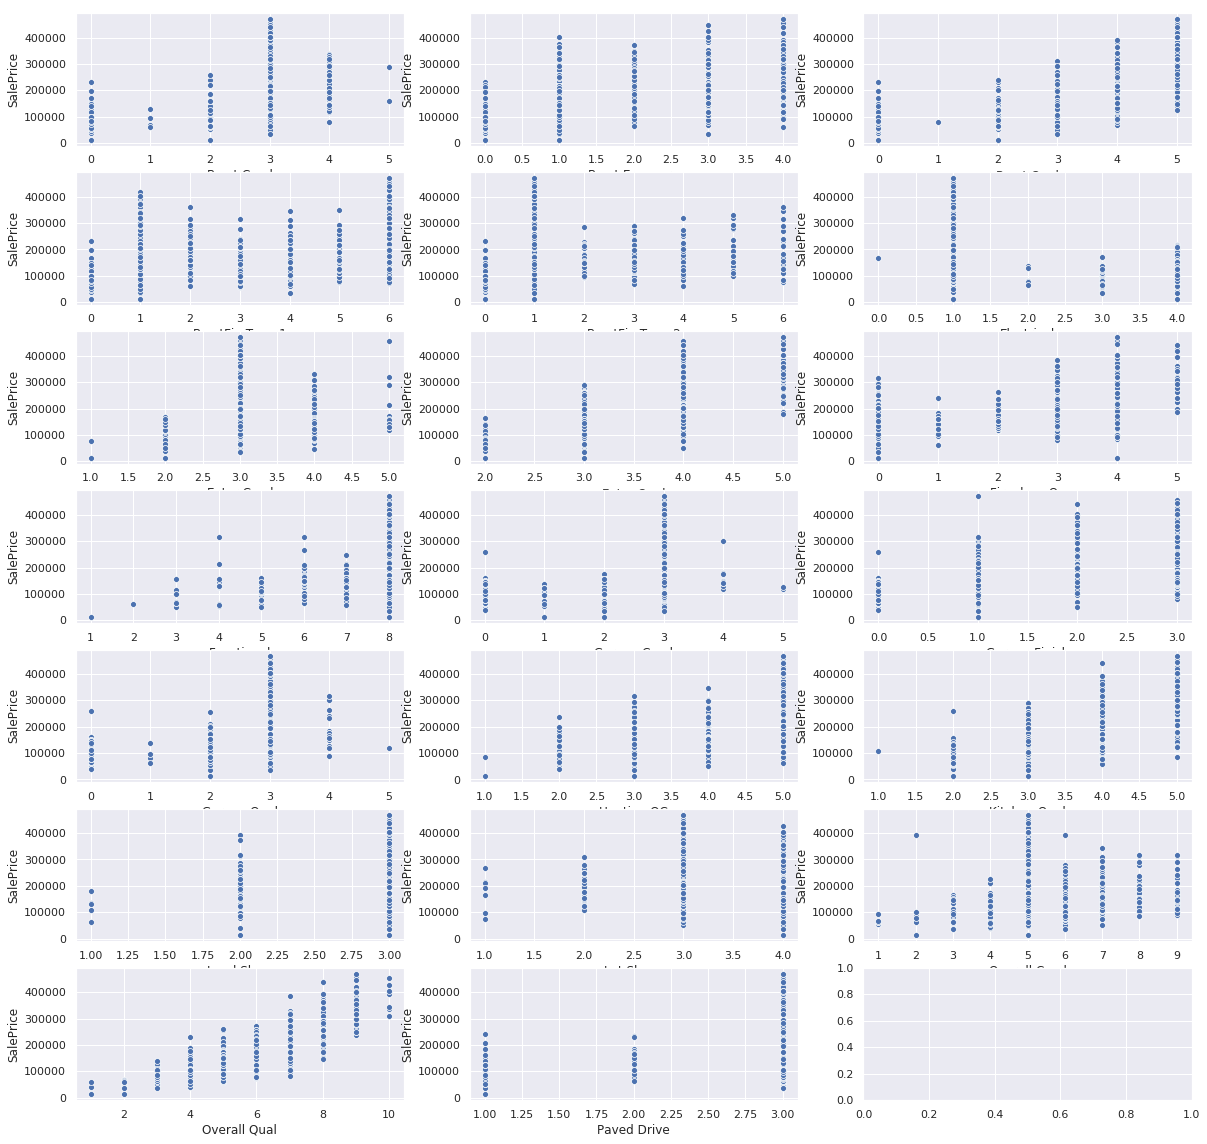

In [17]:
data_scatter(transformData(data)[ordinal+['SalePrice']], 'SalePrice',zlim=50, ncols=3, figsize=(20,20),hue=None)

for 'Garage Qual','Garage Cond' : the value 5 contains only one value. Let's drop them.

In [18]:
data.drop(data[(transformData(data)[['Garage Qual','Garage Cond']] > 4.5).any(axis=1)].index, inplace=True)

In [19]:
data.shape

(2171, 81)

For categorical data :

we will remove catagorical data with values less the 0.1% of data. 

In [20]:
d = transformData(data)
for col in discrete+categorical+ordinal:
    print(col, sum(d[col].value_counts() / np.float(len(data)) < 0.001))
    for idx,val in (d[col].value_counts() / np.float(len(data)) < 0.001).items():
        if val:
            data.drop(data[(d[col]==idx)].index, inplace=True)

Year Built 14
Year Remod/Add 0
Bsmt Full Bath 0
Bsmt Half Bath 0
Full Bath 0
Half Bath 0
Bedroom AbvGr 0
Kitchen AbvGr 0
TotRms AbvGrd 2
Fireplaces 0
Garage Yr Blt 10


/home/vagrant/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Garage Cars 0
Mo Sold 0
Yr Sold 0
MS SubClass 1
MS Zoning 2
Land Contour 0
Lot Config 0
Neighborhood 2
Condition 1 0
Condition 2 5
Bldg Type 0
House Style 0
Roof Style 1
Roof Matl 2
Exterior 1st 5
Exterior 2nd 2
Mas Vnr Type 0
Foundation 0
Heating 2
Central Air 0
Garage Type 0
Misc Feature 1
Sale Type 1
Sale Condition 0
Lot Shape 0
Land Slope 0
Overall Qual 0
Overall Cond 0
Exter Qual 0
Exter Cond 1
Bsmt Qual 1
Bsmt Cond 1
Bsmt Exposure 0
BsmtFin Type 1 0
BsmtFin Type 2 0
Heating QC 1
Kitchen Qual 1
Functional 2
Fireplace Qu 0
Garage Finish 0
Garage Qual 0
Garage Cond 0
Paved Drive 0
Electrical 1


In [21]:
data.shape

(2102, 81)

### Handing missing values

In [22]:
pd.concat([data[numeric].describe().T, pd.DataFrame([data[numeric].nunique().rename('Distinct values'), data[numeric].isnull().sum(axis=0).rename('Null values')]).T], axis=1).sort_values('Null values', ascending=False)

count           mean           std      min        25%  \
Lot Frontage    1741.0      66.792648     19.973289     21.0      56.00   
Mas Vnr Area    2084.0      82.195777    130.947506      0.0       0.00   
Garage Area     2101.0     455.560685    195.576661      0.0     312.00   
1st Flr SF      2102.0    1110.948620    330.350816    407.0     864.00   
2nd Flr SF      2102.0     314.880114    399.832042      0.0       0.00   
Bsmt Unf SF     2102.0     550.129876    426.808398      0.0     217.25   
BsmtFin SF 1    2102.0     408.747383    394.283606      0.0       0.00   
BsmtFin SF 2    2102.0      48.475737    162.802345      0.0       0.00   
Enclosed Porch  2102.0      20.847288     56.324010      0.0       0.00   
Gr Liv Area     2102.0    1429.295433    421.851213    407.0    1097.00   
Lot Area        2102.0    9224.211703   3462.564535   1470.0    7255.00   
Open Porch SF   2102.0      41.557564     53.870553      0.0       0.00   
SalePrice       2102.0  170428.484301  63455.318430  12789.0  128000.00   
Screen Porch    2102.0      11.926736     43.565347      0.0       0.00   
Total Bsmt SF   2102.0    1007.352997    377.648638      0.0     782.25   
Wood Deck SF    2102.0      88.577069    115.124494      0.0       0.00   

                     50%        75%       max  Distinct values  Null values  
Lot Frontage        66.0      80.00     140.0              105          361  
Mas Vnr Area         0.0     144.00     600.0              335           18  
Garage Area        467.0     572.00     984.0              495            1  
1st Flr SF        1056.0    1327.75    2259.0              881            0  
2nd Flr SF           0.0     682.25    1427.0              487            0  
Bsmt Unf SF        461.5     795.75    1967.0              954            0  
BsmtFin SF 1       360.0     700.00    1500.0              802            0  
BsmtFin SF 2         0.0       0.00    1127.0              212            0  
Enclosed Porch       0.0       0.00     368.0              142            0  
Gr Liv Area       1392.0    1688.75    2978.0             1026            0  
Lot Area          9178.5   11075.00   22692.0             1455            0  
Open Porch SF       24.0      64.00     250.0              193            0  
SalePrice       156966.0  202000.00  470000.0              790            0  
Screen Porch         0.0       0.00     240.0               79            0  
Total Bsmt SF      968.0    1228.00    2217.0              855            0  
Wood Deck SF         0.0     165.75     576.0              309            0

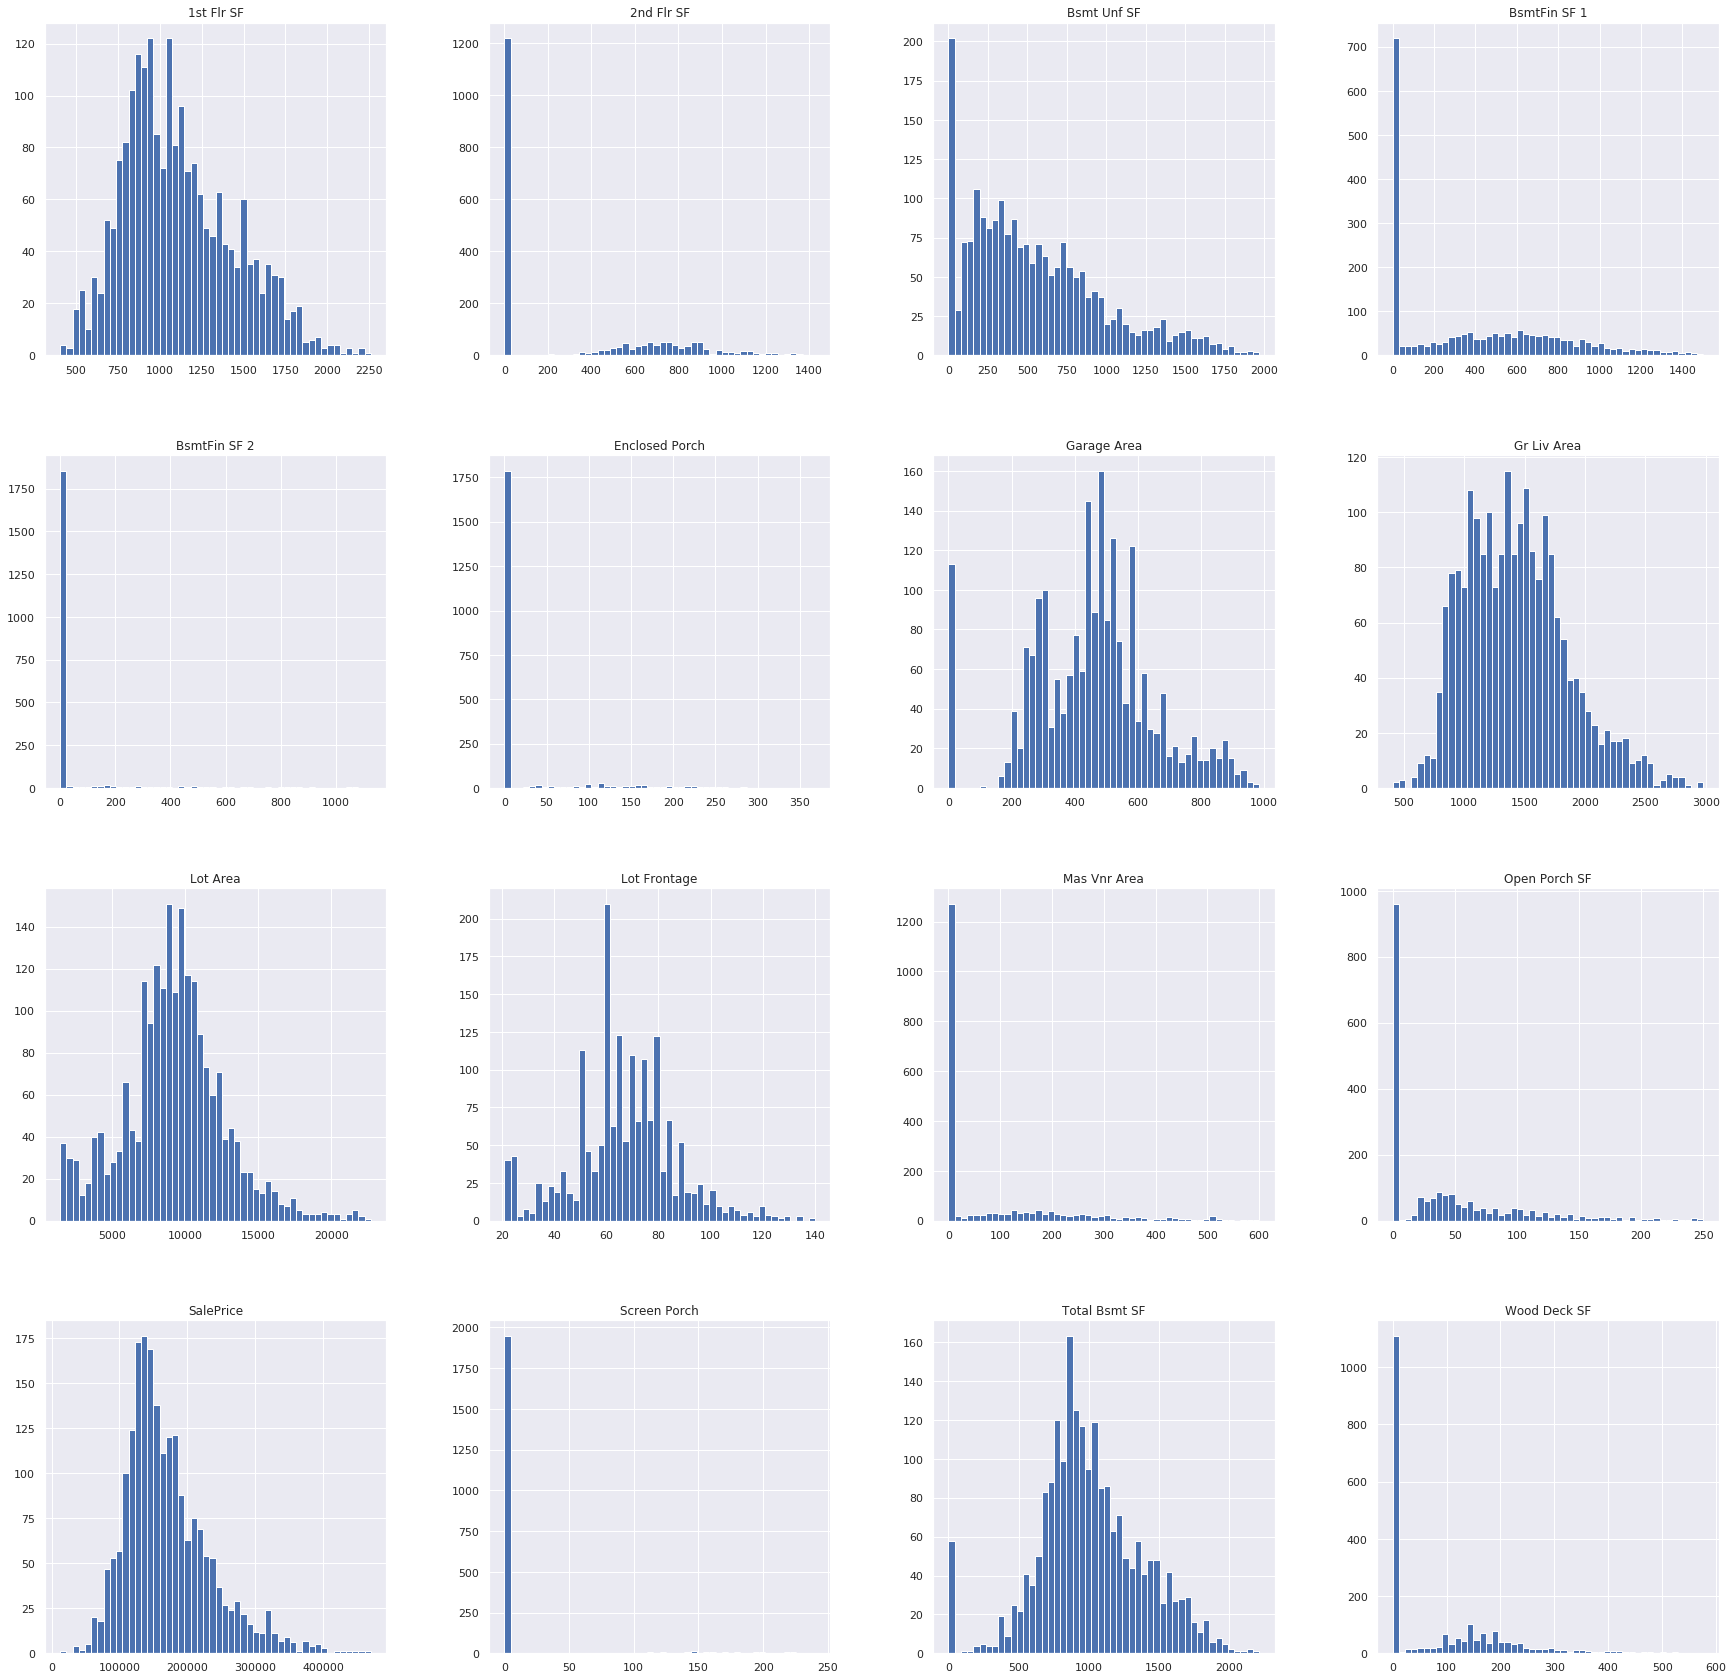

In [23]:
data[numeric].hist(figsize=(30,30),bins=50);

- Lot Frontage, Garage Area : the have a bell shape. We replace mission values with median ( median and mean are quite equal. Median is robust to outliers).
- Mas Vnr Area : most values are 0. We replace mission values with mode (0)

For discrete columns :

In [24]:
pd.concat([data[discrete].describe().T, pd.DataFrame([data[discrete].nunique().rename('Distinct values'), data[discrete].isnull().sum(axis=0).rename('Null values')]).T], axis=1).sort_values('Null values', ascending=False)

count         mean        std     min     25%     50%  \
Garage Yr Blt   1987.0  1977.700050  24.769504  1900.0  1960.0  1978.0   
Garage Cars     2101.0     1.717277   0.716494     0.0     1.0     2.0   
Year Built      2102.0  1971.546147  29.275018  1890.0  1954.0  1973.0   
Year Remod/Add  2102.0  1983.902474  20.787346  1950.0  1965.0  1992.0   
Bsmt Full Bath  2102.0     0.413416   0.504026     0.0     0.0     0.0   
Bsmt Half Bath  2102.0     0.057088   0.232067     0.0     0.0     0.0   
Full Bath       2102.0     1.530923   0.528795     0.0     1.0     2.0   
Half Bath       2102.0     0.358230   0.494257     0.0     0.0     0.0   
Bedroom AbvGr   2102.0     2.820647   0.776065     0.0     2.0     3.0   
Kitchen AbvGr   2102.0     1.038059   0.191384     1.0     1.0     1.0   
TotRms AbvGrd   2102.0     6.268792   1.417094     3.0     5.0     6.0   
Fireplaces      2102.0     0.544244   0.614510     0.0     0.0     0.0   
Mo Sold         2102.0     6.198382   2.702113     1.0     4.0     6.0   
Yr Sold         2102.0  2007.793530   1.316680  2006.0  2007.0  2008.0   

                   75%     max  Distinct values  Null values  
Garage Yr Blt   2001.0  2010.0               89          115  
Garage Cars        2.0     3.0                4            1  
Year Built      2000.0  2009.0               96            0  
Year Remod/Add  2003.0  2010.0               61            0  
Bsmt Full Bath     1.0     2.0                3            0  
Bsmt Half Bath     0.0     1.0                2            0  
Full Bath          2.0     3.0                4            0  
Half Bath          1.0     2.0                3            0  
Bedroom AbvGr      3.0     6.0                7            0  
Kitchen AbvGr      1.0     2.0                2            0  
TotRms AbvGrd      7.0    12.0               10            0  
Fireplaces         1.0     3.0                4            0  
Mo Sold            8.0    12.0               12            0  
Yr Sold         2009.0  2010.0                5            0

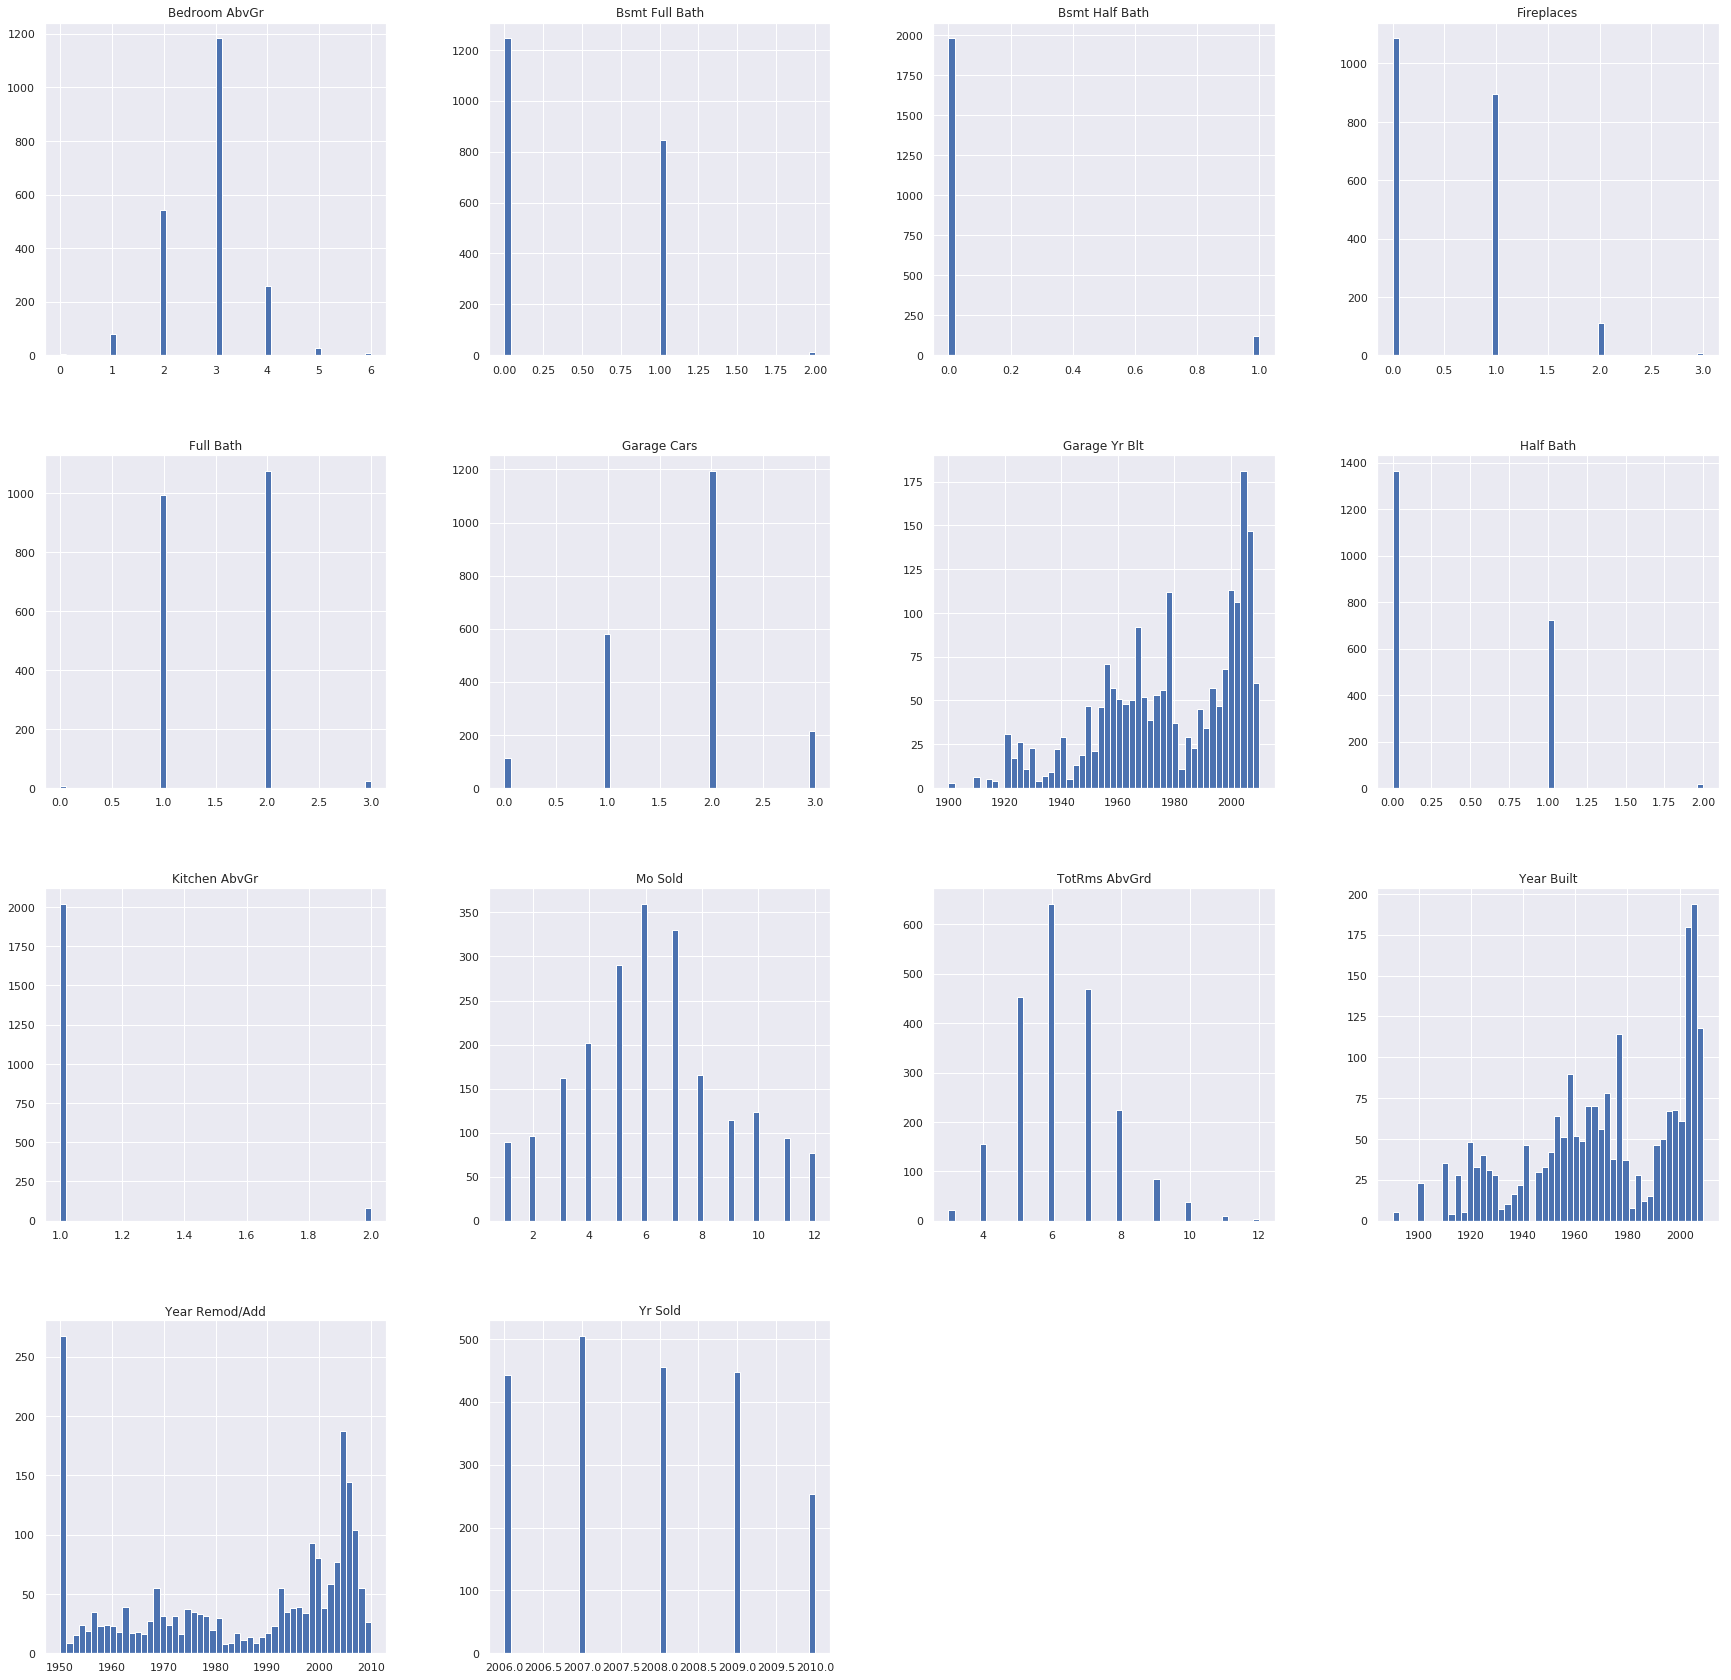

In [25]:
data[discrete].hist(figsize=(30,30),bins=50);

using same logic, we will replace missing values for "Garage Yr Blt" and "Garage Cars" with median.

The function transformData will be modified to fill missing values.

In [26]:
median_cols = ['Lot Frontage', 'Garage Area', 'Total Bsmt SF', 'Bsmt Unf SF', 'Garage Yr Blt', 'Garage Cars']
mode_cols = ['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Full Bath', 'Bsmt Half Bath']
def transformData(X):
    # replace values in ordinal and categorical features with new values from dic
    X_ = X.replace(data_dic)
    for col in X_.columns.intersection(data_dic.keys()):
       X_[col] = X_[col].astype(np.int64)
    # fillna with median and mode
    X_ = X_.fillna(X_[X_.columns.intersection(median_cols)].median().to_dict())
    X_ = X_.fillna(X_[X_.columns.intersection(mode_cols)].mode().iloc[0].to_dict())               
    return X_.drop(['PID','Low Qual Fin SF','Misc Val', 'Pool Area','3Ssn Porch','Pool QC','Utilities', 'Alley', 'Fence', 'Street'],axis=1)

Let's check number of null values after transformation.

In [27]:
transformData(data).isnull().sum(axis=0).sum()

0

## Feature engineering
Your analysis should also include feature engineering. Here are a few ideas
- Create indicator variables ex. year of construction is older than some threshold
- Transformations ex. log-transforms, polynomials
Suggestion: write down your feature engineering ideas during the data exploration stage.


#### Normality tests and effect of applying log transformation

To test normality, we use here two functions of scipy :
- normaltest : Test whether a sample differs from a normal distribution. It's based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.
- shapiro : Perform the Shapiro-Wilk test for normality.The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

To try to improve normality, we use here :
- log1p : which is a numpy function which apply $log(1+x)$ function. We use $log1p$ isntead of $log$ because there is zeros in numeric data. All numeric data values are positive.
- yeojohnson : Return a dataset transformed by a Yeo-Johnson power transformation. Yeo-Johnson is a power transformation that can improve normality of a distribution.

In [28]:
# returns p-value. reject if p-value < significance level
# the lower the p-value, the less distribution looks normal
def normal_test(x):
    return normaltest(x)[1]
def shapiro_test(x):
    return shapiro(x)[1]
def trans_yeojohnson(x):
    return yeojohnson(x)[0]
df = pd.DataFrame({'normal':transformData(data)[numeric].apply(normal_test),
              'shapiro':transformData(data)[numeric].apply(shapiro_test),
              'normal (log)':transformData(data)[numeric].apply(np.log1p).apply(normal_test),
              'shapiro (log)':transformData(data)[numeric].apply(np.log1p).apply(shapiro_test),
              'normal (YeoJohnson)':transformData(data)[numeric].apply(trans_yeojohnson).apply(normal_test),
              'shapiro (YeoJohnson)':transformData(data)[numeric].apply(trans_yeojohnson).apply(shapiro_test)

             }).sort_values('normal', ascending=False)
df['distribution_looks_normal'] = df['normal'] > 0.05
df['log_improve_normality'] = df['normal'] < df['normal (log)']
df['yj_improve_normality'] = df['normal'] < df['normal (YeoJohnson)']
df

normal       shapiro   normal (log)  shapiro (log)  \
Garage Area      4.308561e-03  9.618296e-18   0.000000e+00   0.000000e+00   
Total Bsmt SF    8.065502e-04  4.890189e-16   0.000000e+00   0.000000e+00   
Lot Area         6.026645e-16  1.840842e-16  1.905977e-115   4.501465e-36   
Lot Frontage     1.588577e-17  4.119140e-24  3.316233e-117   3.249978e-37   
1st Flr SF       1.639611e-23  3.803983e-20   2.320808e-03   1.371596e-07   
Gr Liv Area      1.056403e-24  1.165702e-18   1.944003e-03   7.444267e-07   
Bsmt Unf SF      3.130857e-45  4.815272e-30  2.139255e-190   0.000000e+00   
BsmtFin SF 1     1.396525e-46  1.028550e-36   0.000000e+00   0.000000e+00   
SalePrice        6.817973e-81  2.884292e-29   1.398478e-19   5.430708e-12   
Wood Deck SF     6.127976e-87  0.000000e+00   0.000000e+00   0.000000e+00   
2nd Flr SF       2.158913e-90  0.000000e+00   0.000000e+00   0.000000e+00   
Open Porch SF   2.394849e-115  0.000000e+00   0.000000e+00   0.000000e+00   
Mas Vnr Area    1.548430e-131  0.000000e+00   0.000000e+00   0.000000e+00   
Enclosed Porch  7.930536e-269  0.000000e+00  3.935975e-163   0.000000e+00   
BsmtFin SF 2     0.000000e+00  0.000000e+00  7.755212e-216   0.000000e+00   
Screen Porch     0.000000e+00  0.000000e+00  7.418234e-301   0.000000e+00   

                normal (YeoJohnson)  shapiro (YeoJohnson)  \
Garage Area            4.347884e-18          2.291726e-22   
Total Bsmt SF          8.159637e-12          7.541042e-19   
Lot Area               2.687920e-06          3.977906e-15   
Lot Frontage           1.366514e-16          4.206070e-24   
1st Flr SF             1.428552e-03          8.162421e-07   
Gr Liv Area            3.035791e-02          8.398083e-05   
Bsmt Unf SF            1.176976e-09          7.435842e-19   
BsmtFin SF 1           0.000000e+00          1.261169e-44   
SalePrice              2.104390e-07          1.863446e-09   
Wood Deck SF           0.000000e+00          0.000000e+00   
2nd Flr SF             0.000000e+00          0.000000e+00   
Open Porch SF          0.000000e+00          0.000000e+00   
Mas Vnr Area           0.000000e+00          0.000000e+00   
Enclosed Porch        3.733655e-153          0.000000e+00   
BsmtFin SF 2          1.650724e-201          0.000000e+00   
Screen Porch          1.705183e-298          0.000000e+00   

                distribution_looks_normal  log_improve_normality  \
Garage Area                         False                  False   
Total Bsmt SF                       False                  False   
Lot Area                            False                  False   
Lot Frontage                        False                  False   
1st Flr SF                          False                   True   
Gr Liv Area                         False                   True   
Bsmt Unf SF                         False                  False   
BsmtFin SF 1                        False                  False   
SalePrice                           False                   True   
Wood Deck SF                        False                  False   
2nd Flr SF                          False                  False   
Open Porch SF                       False                  False   
Mas Vnr Area                        False                  False   
Enclosed Porch                      False                   True   
BsmtFin SF 2                        False                   True   
Screen Porch                        False                   True   

                yj_improve_normality  
Garage Area                    False  
Total Bsmt SF                  False  
Lot Area                        True  
Lot Frontage                    True  
1st Flr SF                      True  
Gr Liv Area                     True  
Bsmt Unf SF                     True  
BsmtFin SF 1                   False  
SalePrice                       True  
Wood Deck SF                   False  
2nd Flr SF                     False  
Open Porch SF                  False  
Mas Vnr Are

Here is some conclusions :
- All Numeric data does not follow a normal distribution.
- Log application improves normality for some columns
- Yeo-Johnson method improves normality for more columns than log transformation

We will include Yeo-Johnson transformation in our pipeline.

#### Adding extra features

- Condition 1 and 2 :

If we add them, correlation with saleprice is improved

In [29]:
tmp = transformData(data)[['Condition 1','Condition 2','SalePrice']].copy()
tmp['FE_Condition'] = tmp ['Condition 1'] + tmp ['Condition 2']
tmp.corr()[['SalePrice']]

SalePrice
Condition 1    0.093315
Condition 2    0.065529
SalePrice      1.000000
FE_Condition   0.103308

- Overall Qual and Cond :

If we add them, correlation with saleprice is improved significantly

In [30]:
tmp = transformData(data)[['Overall Qual','Overall Cond','SalePrice']].copy()
tmp['FE_Overall'] = tmp ['Overall Qual'] + tmp ['Overall Cond']
tmp.corr()[['SalePrice']]

SalePrice
Overall Qual   0.810656
Overall Cond  -0.115453
SalePrice      1.000000
FE_Overall     0.581771

- Total Square Feet :

If we add square feet of all house stages, correlation with saleprice is improved significantly

In [31]:
tmp = transformData(data)[['Total Bsmt SF','1st Flr SF','2nd Flr SF','SalePrice']].copy()
tmp['FE_totalSF'] = tmp ['Total Bsmt SF'] + tmp ['1st Flr SF'] + tmp ['2nd Flr SF'] 
tmp.corr()[['SalePrice']]

SalePrice
Total Bsmt SF   0.598309
1st Flr SF      0.569867
2nd Flr SF      0.279574
SalePrice       1.000000
FE_totalSF      0.804308

- Year Built, Garage Yr Blt

If we plot sales vs year built, we can see that there non-linear dependence between them :

Adding a polynomial feature can improve our model.

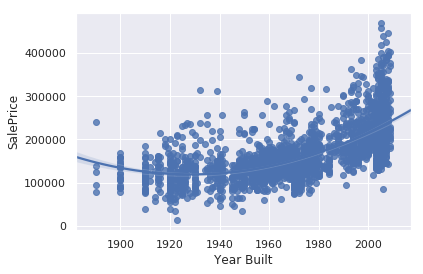

In [32]:
# plot data with and order 2 polynomial regression
sns.regplot(data=transformData(data),x='Year Built',y='SalePrice',order=2);

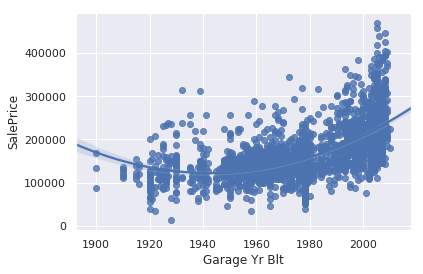

In [33]:
sns.regplot(data=transformData(data),x='Garage Yr Blt',y='SalePrice',order=2);

We will change transformData function to incorporate all these changes :

In [34]:
def transformData(X):
    # replace values in ordinal and categorical features with new values from dic
    X_ = X.replace(data_dic)
    for col in X_.columns.intersection(data_dic.keys()):
       X_[col] = X_[col].astype(np.int64)
    # fillna with median and mode
    X_ = X_.fillna(X_[X_.columns.intersection(median_cols)].median().to_dict())
    X_ = X_.fillna(X_[X_.columns.intersection(mode_cols)].mode().iloc[0].to_dict())      
    # create new features
    X_['FE_Condition'] = X_['Condition 1'] + X_['Condition 2']
    X_['FE_Overall'] = X_['Overall Qual'] + X_['Overall Cond']
    X_['FE_totalSF'] = X_['Total Bsmt SF'] + X_['1st Flr SF'] + X_['2nd Flr SF'] 
    X_['FE_YearBuilt'] = X_['Year Built'].pow(2)
    X_['FE_GrgYearBuilt'] = X_['Garage Yr Blt'].pow(2)
    return X_.drop(['PID','Low Qual Fin SF','Misc Val', 'Pool Area','3Ssn Porch','Pool QC','Utilities', 'Alley', 'Fence', 'Street'],axis=1)
ordinal=['Lot Shape','Land Slope','FE_Overall','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond',
         'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Kitchen Qual','Functional','Fireplace Qu','Garage Finish',
         'Garage Qual','Garage Cond','Paved Drive','Electrical']
numeric = ['FE_totalSF', 'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Enclosed Porch', 'Garage Area', 'Gr Liv Area', 'Lot Area',
           'Lot Frontage',  'Mas Vnr Area', 'Open Porch SF',  'SalePrice', 'Screen Porch', 'Wood Deck SF']
categorical=['MS SubClass','MS Zoning','Land Contour','Lot Config','Neighborhood','Bldg Type',
             'House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air',
             'Garage Type','Misc Feature','Sale Type','Sale Condition','FE_Condition']
discrete=['Year Built','Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Yr Blt',
          'Garage Cars','Mo Sold','Yr Sold', 'FE_YearBuilt', 'FE_GrgYearBuilt']

## Model fitting
Your analysis should include an appropriate baseline and evaluate three different models
ranging in complexity
- A simple model with two variables (three with the target variable)
- An intermediate model (between 10 and 20 variables)
- A complex model with all variables
The number of variables is only given as an indication, it's not a strict range. Also, it
corresponds to the variables count before one-hot encoding. For the simple and
intermediate models, you can choose the variables. You are free to choose your preferred
approach for this variable selection step, but you should include a short comment to
explain your choice.

## Simple model

In order to select variables for simple model, let's begin by studying correlation between them and SalePrice.

### Study correlation
##### Categorical

We will display boxplot for all categorical variables

/home/vagrant/anaconda3/envs/exts-ml/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/vagrant/anaconda3/envs/exts-ml/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


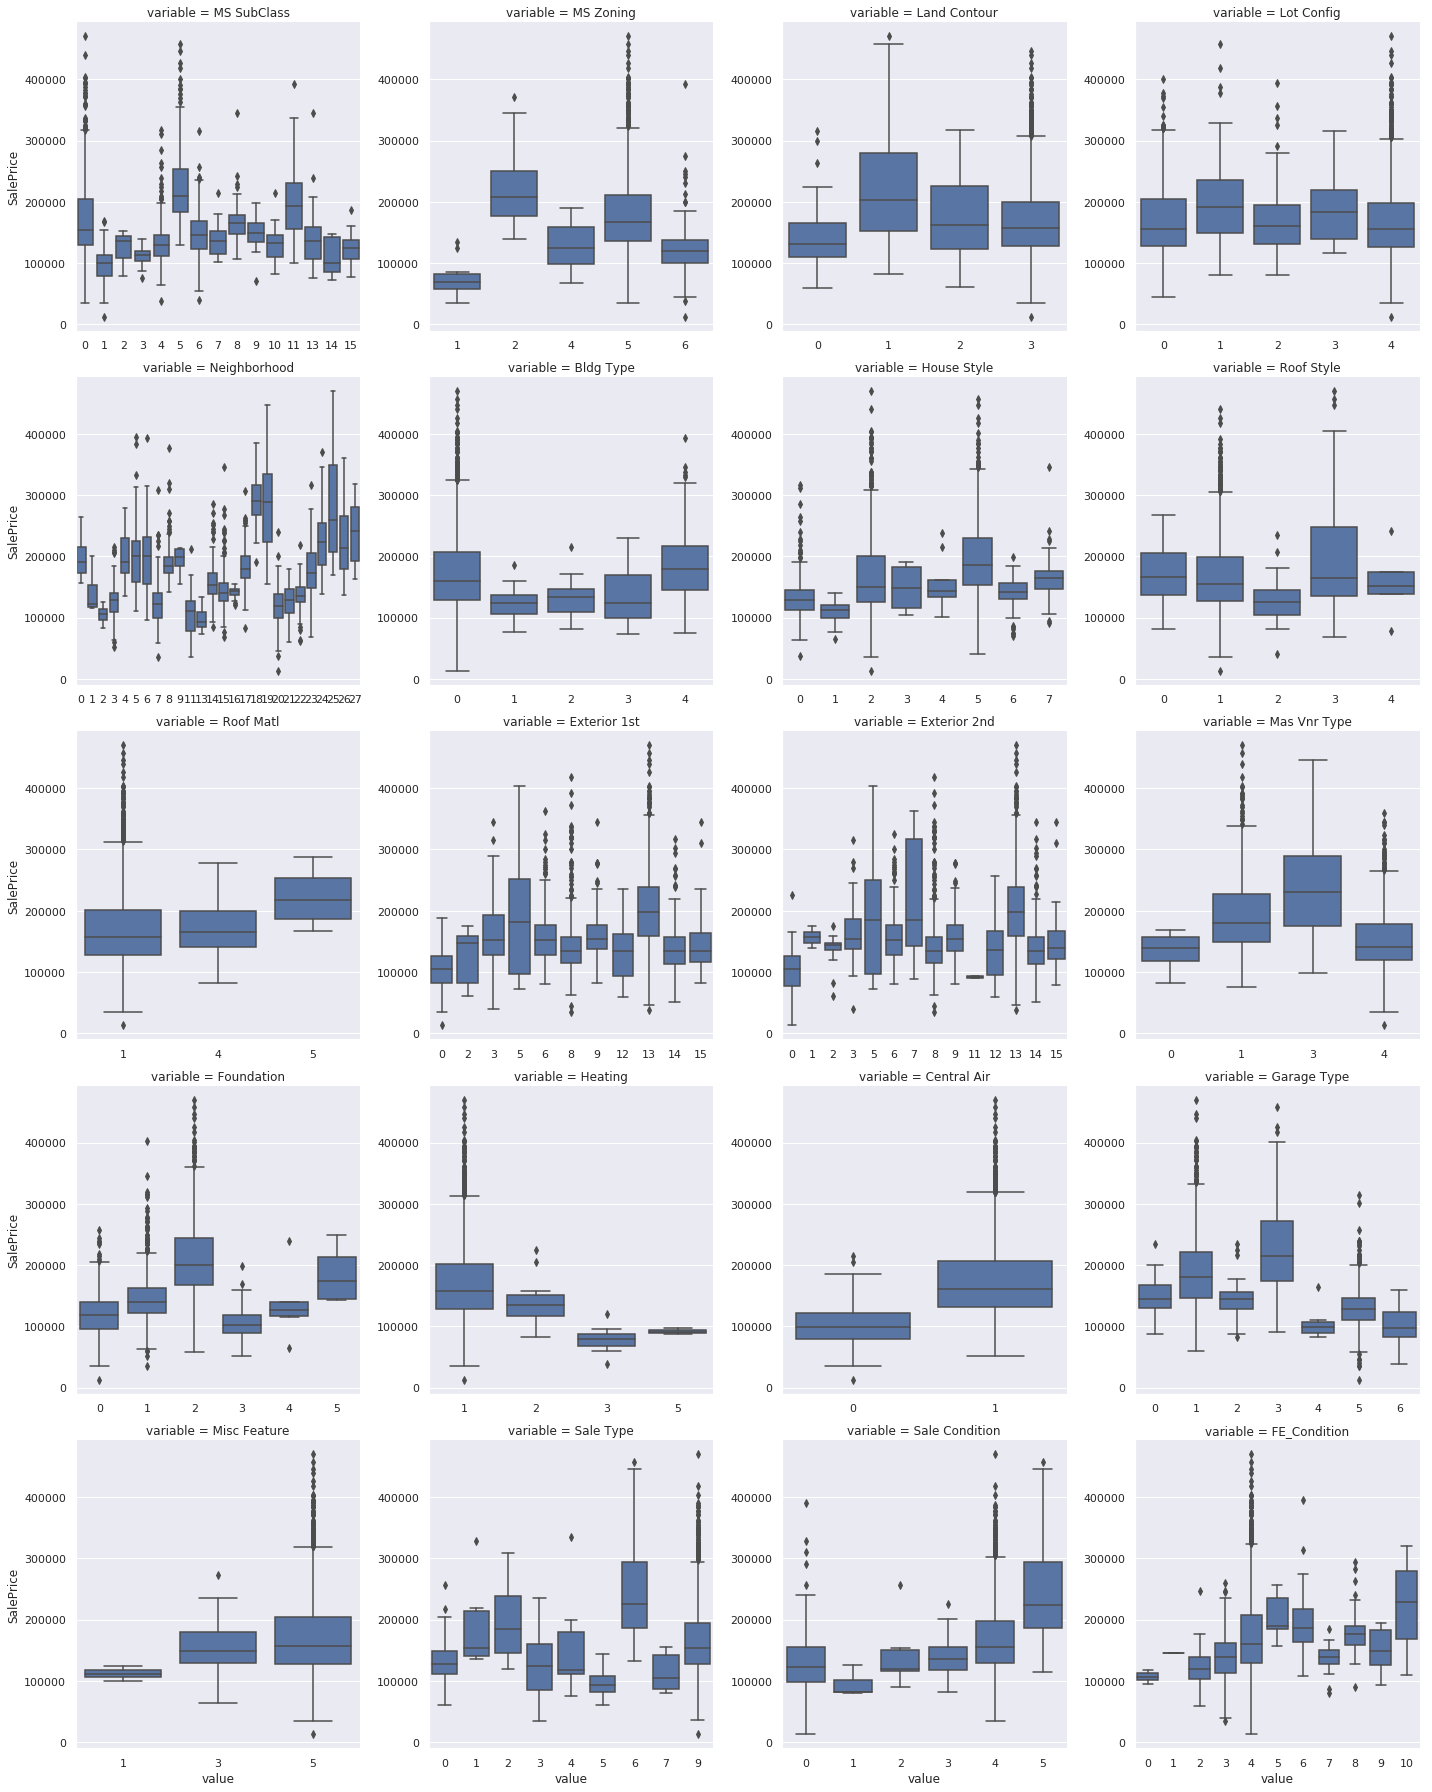

In [35]:
sns.FacetGrid(pd.melt(transformData(data), id_vars=['SalePrice'], value_vars=categorical), col="variable",  col_wrap=4, sharex=False, sharey=False, size=5).map(sns.boxplot, "value", "SalePrice");

We need to measure this correlation. Diffrent methods exists for this purpose.
#### Measuring the correlation between variables and salesprice

##### for categorical, ordinal and discrete variables
There are multiple methods to do that, for example :
- One-way ANOVA H-test : based on **mean**. Distribution is expected to be normal (which is not the case for most of our variables)
- Kruskal-Wallis H-test : based on **median**, so more robust than anova. Moreover, it does not require normality.

For these two tests, the more p-value is small, the best correlation we have. If p-value is small, We reject the H0 hypothesis : "mean(or median) of each group are equal".

For interpretation, we will use the Kruskal-Wallis H-test results because it does not depend on normality.

For categorical variables:

In [36]:
# The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean.
def anova_test(x):
    return f_oneway(*[data[x==v]['SalePrice'].values for v in x.unique()])[1][0]
# The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. 
def kruskal_test(x):
    return kruskal(*[data[x==v]['SalePrice'].values for v in x.unique()])[1]
pd.DataFrame({'anova':transformData(data)[categorical].apply(anova_test),'kruscal':transformData(data)[categorical].apply(kruskal_test)}).sort_values('kruscal')

anova        kruscal
Neighborhood     0.000000e+00  7.790592e-258
MS SubClass     1.886098e-159  5.843323e-169
Foundation      1.203704e-175  4.837111e-168
Garage Type     2.135467e-155  1.307509e-163
Exterior 1st     1.446432e-93   2.128210e-97
MS Zoning        1.014985e-74   8.684867e-94
Exterior 2nd     3.421169e-90   7.908053e-93
Mas Vnr Type    4.593339e-104   6.721720e-83
House Style      1.467413e-44   1.945912e-54
Central Air      4.111444e-42   2.112733e-51
Sale Condition   8.364016e-62   6.357198e-50
Sale Type        2.478203e-56   3.413510e-43
Bldg Type        2.256611e-21   3.300382e-27
FE_Condition     1.230045e-16   6.744135e-22
Land Contour     2.988845e-15   4.929384e-10
Lot Config       1.607518e-06   5.187672e-08
Heating          2.591095e-05   1.783965e-06
Roof Style       2.387030e-13   2.219433e-06
Misc Feature     3.034808e-02   6.086889e-02
Roof Matl        2.591327e-01   1.516482e-01

This table represents most correlated columns with SalePrice. The most correlated column with SalePrice is Neighborhood.

For ordinal columns :

/home/vagrant/anaconda3/envs/exts-ml/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/vagrant/anaconda3/envs/exts-ml/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


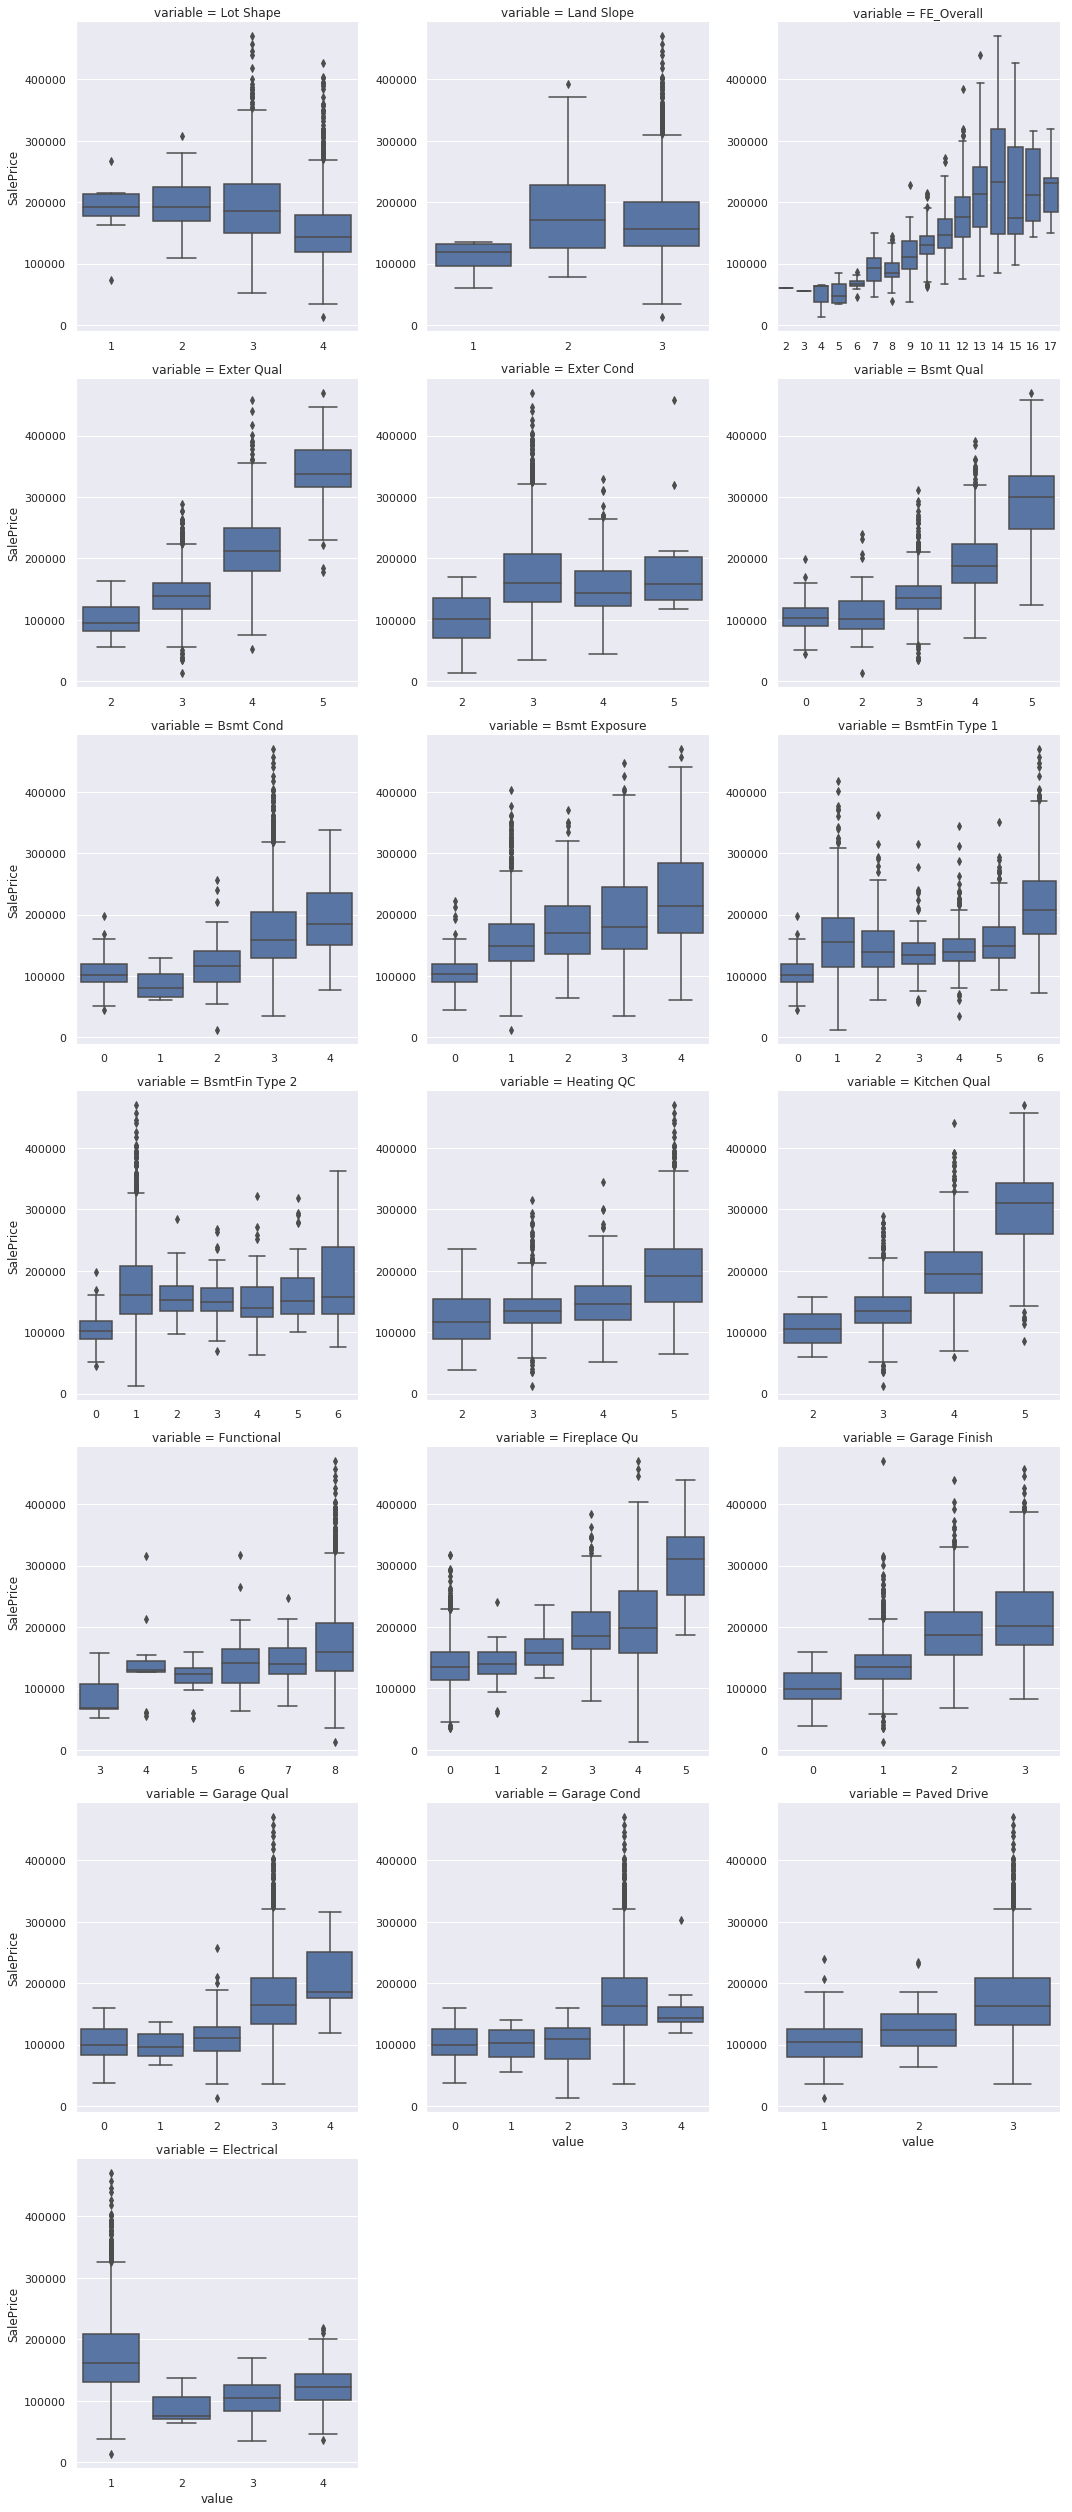

In [37]:
sns.FacetGrid(pd.melt(transformData(data), id_vars=['SalePrice'], value_vars=ordinal), col="variable",  col_wrap=3, sharex=False, sharey=False, size=5).map(sns.boxplot, "value", "SalePrice");

In [38]:
pd.DataFrame({'anova':transformData(data)[ordinal].apply(anova_test),'kruscal':transformData(data)[ordinal].apply(kruskal_test)}).sort_values('kruscal')

anova        kruscal
Bsmt Qual       1.696821e-308  6.395930e-210
Exter Qual      7.791170e-308  8.311878e-206
Kitchen Qual    4.794896e-279  9.647274e-193
Garage Finish   1.479818e-189  1.101355e-183
FE_Overall      5.564353e-194  1.547922e-151
Fireplace Qu    3.915604e-161  6.044126e-132
Heating QC      7.297483e-125  2.268916e-119
BsmtFin Type 1  2.661607e-119  6.976602e-111
Garage Qual      1.233297e-51   3.292148e-65
Garage Cond      3.351916e-47   3.136234e-58
Lot Shape        4.526877e-48   1.122988e-54
Paved Drive      3.054637e-44   4.521497e-54
Bsmt Exposure    1.258480e-65   2.544792e-53
Electrical       5.676783e-31   9.220835e-38
Bsmt Cond        3.152988e-29   1.502293e-37
BsmtFin Type 2   1.684992e-14   1.447448e-18
Exter Cond       3.592722e-15   1.482854e-15
Functional       4.745457e-09   2.994221e-10
Land Slope       4.294108e-02   3.264190e-02

for discrete columns :

/home/vagrant/anaconda3/envs/exts-ml/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/vagrant/anaconda3/envs/exts-ml/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


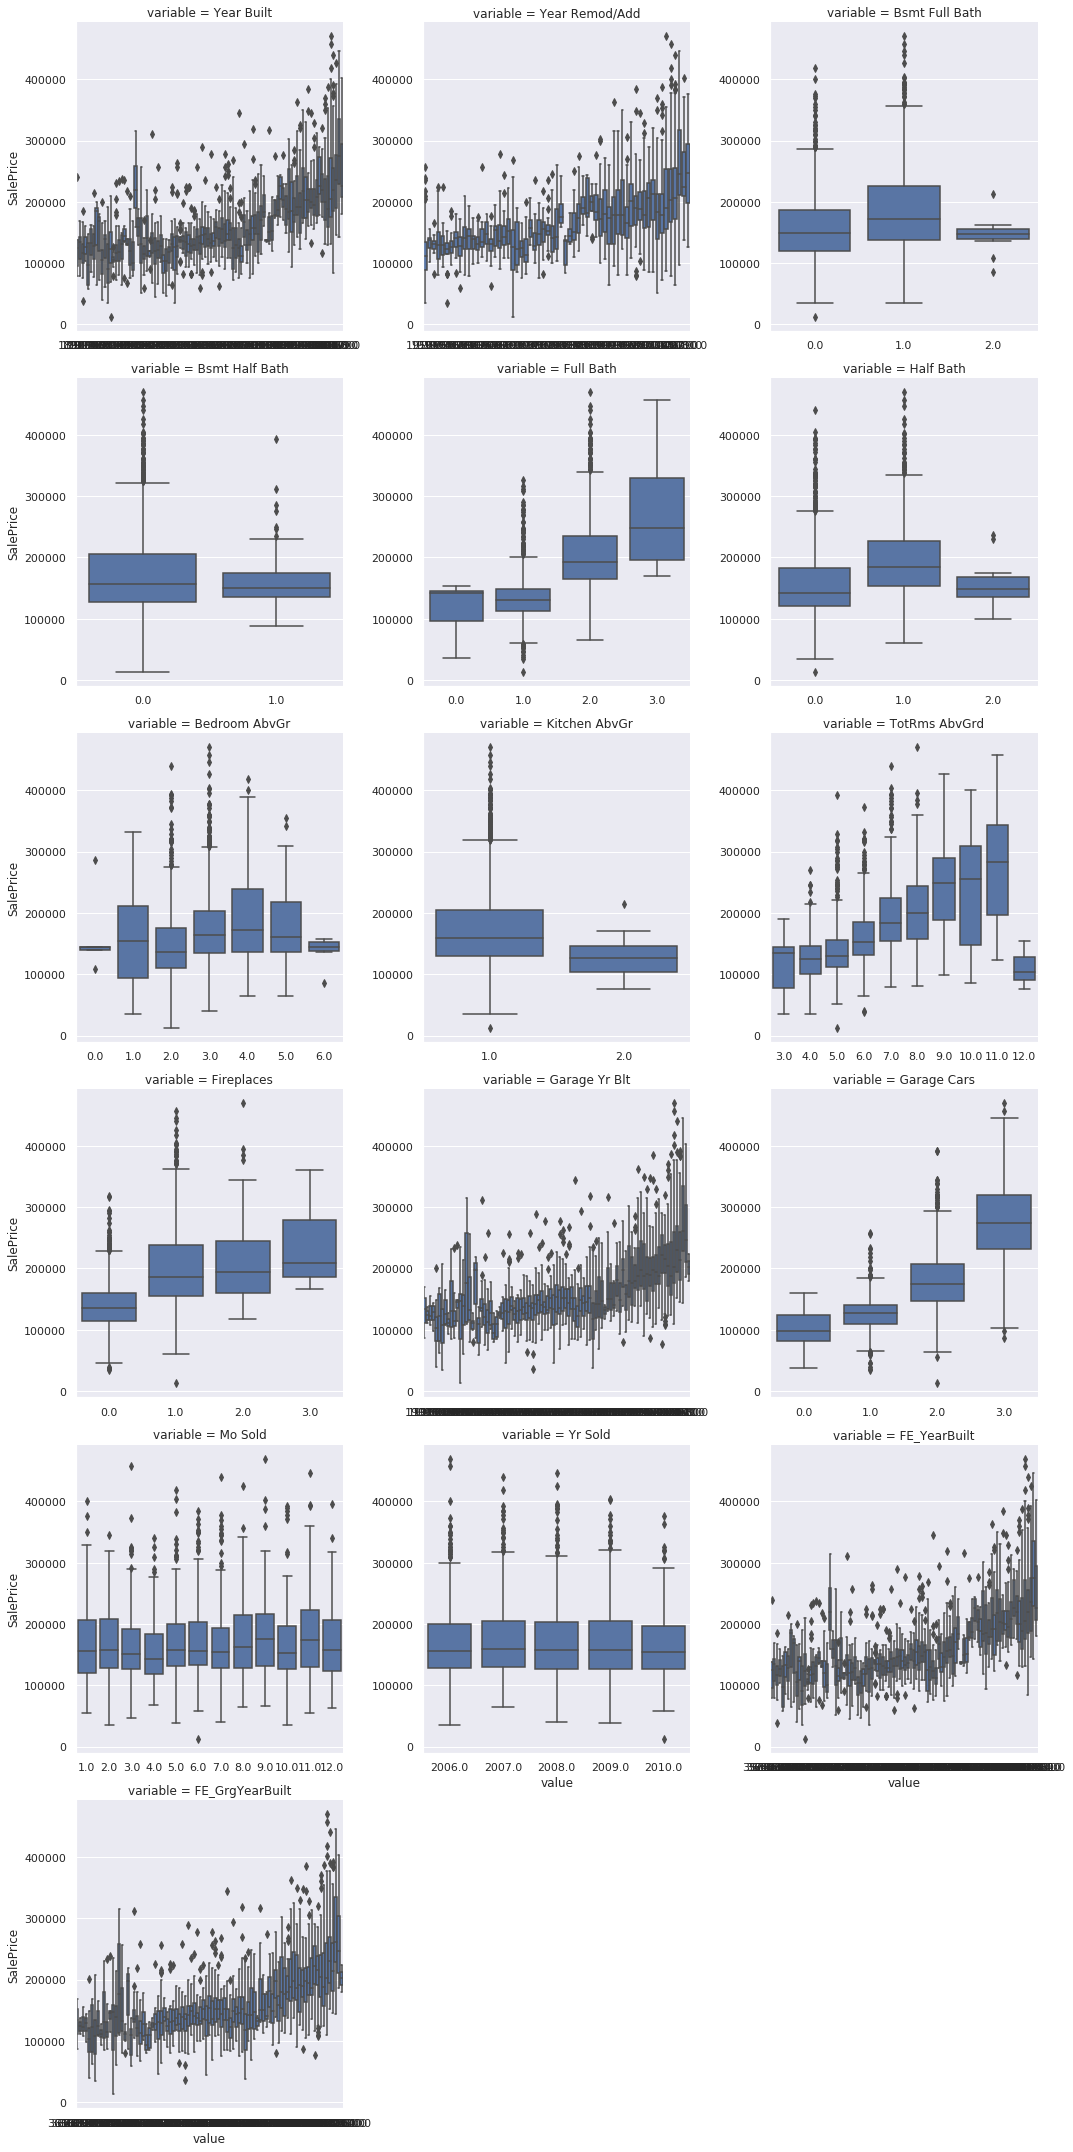

In [39]:
sns.FacetGrid(pd.melt(transformData(data), id_vars=['SalePrice'], value_vars=discrete), col="variable",  col_wrap=3, sharex=False, sharey=False, size=5).map(sns.boxplot, "value", "SalePrice");

In [40]:
pd.DataFrame({'anova':transformData(data)[discrete].apply(anova_test),'kruscal':transformData(data)[discrete].apply(kruskal_test)}).sort_values('kruscal')

anova        kruscal
Garage Cars      3.768740e-302  1.753731e-216
Full Bath        5.910305e-191  1.076751e-191
Year Built       7.064880e-235  7.014068e-191
FE_YearBuilt     7.064880e-235  7.014068e-191
Garage Yr Blt    1.255048e-205  7.537181e-164
FE_GrgYearBuilt  1.255048e-205  7.537181e-164
Year Remod/Add   1.407552e-157  4.654770e-142
Fireplaces       8.966562e-125  4.643321e-118
TotRms AbvGrd    6.502848e-127  1.086522e-107
Half Bath         6.599519e-43   7.872191e-52
Bsmt Full Bath    1.940851e-30   1.141301e-23
Bedroom AbvGr     6.559033e-19   1.467319e-23
Kitchen AbvGr     9.835294e-11   1.326053e-13
Mo Sold           8.227253e-03   4.312856e-02
Bsmt Half Bath    4.091804e-02   1.474170e-01
Yr Sold           4.322848e-01   6.758087e-01

##### for quantitative variables

To measure correlation between quantitative variables, many methods are available. Fro example :pearson, kendall and spearman.

Pearson correlation makes assumption that distribution is normal. Spearman and Kendall doesn't make this assumption.

The following table lists correlation between variables using three methods : pearson, kendall and spearman.

We will use spearman for interpretation because it makes no assumption of normality.

In [41]:
corr_cols = ['SalePrice']+list(set(numeric)-set(['SalePrice']))
tmp = transformData(data)[corr_cols].copy()
pd.DataFrame({m:tmp.corr(method=m)['SalePrice'] for m in ['pearson','kendall','spearman']}).sort_values('spearman',ascending=False)

pearson   kendall  spearman
SalePrice       1.000000  1.000000  1.000000
FE_totalSF      0.804308  0.621309  0.802305
Gr Liv Area     0.705177  0.522696  0.710567
Garage Area     0.636431  0.471258  0.641245
Open Porch SF   0.390915  0.357395  0.487083
Mas Vnr Area    0.445835  0.318308  0.417083
Lot Area        0.358170  0.264024  0.384010
Lot Frontage    0.334080  0.242859  0.341520
Wood Deck SF    0.306679  0.247396  0.336993
BsmtFin SF 1    0.363341  0.212698  0.292916
Bsmt Unf SF     0.200063  0.124056  0.181069
Screen Porch    0.056768  0.051984  0.064662
BsmtFin SF 2   -0.016568 -0.033274 -0.042037
Enclosed Porch -0.162536 -0.188675 -0.240890

The most numeric variables correlated with Sales are FE_totalSF and 'Gr Liv Area'. 

We will plot the heatmap of correlation.

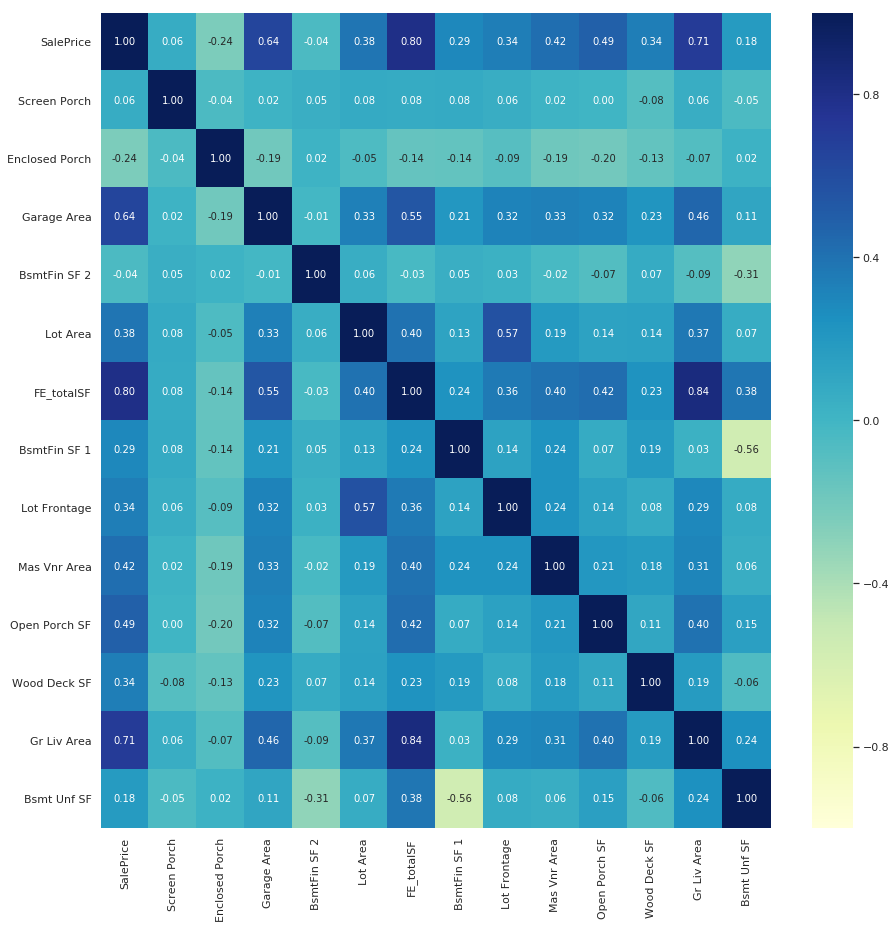

In [42]:
plt.figure(figsize=(15,15))
corr = tmp.corr(method='spearman')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, annot=True,fmt=".2f", cmap="YlGnBu");

These regression charts illustrate the same conclusions for correlation.

/home/vagrant/anaconda3/envs/exts-ml/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


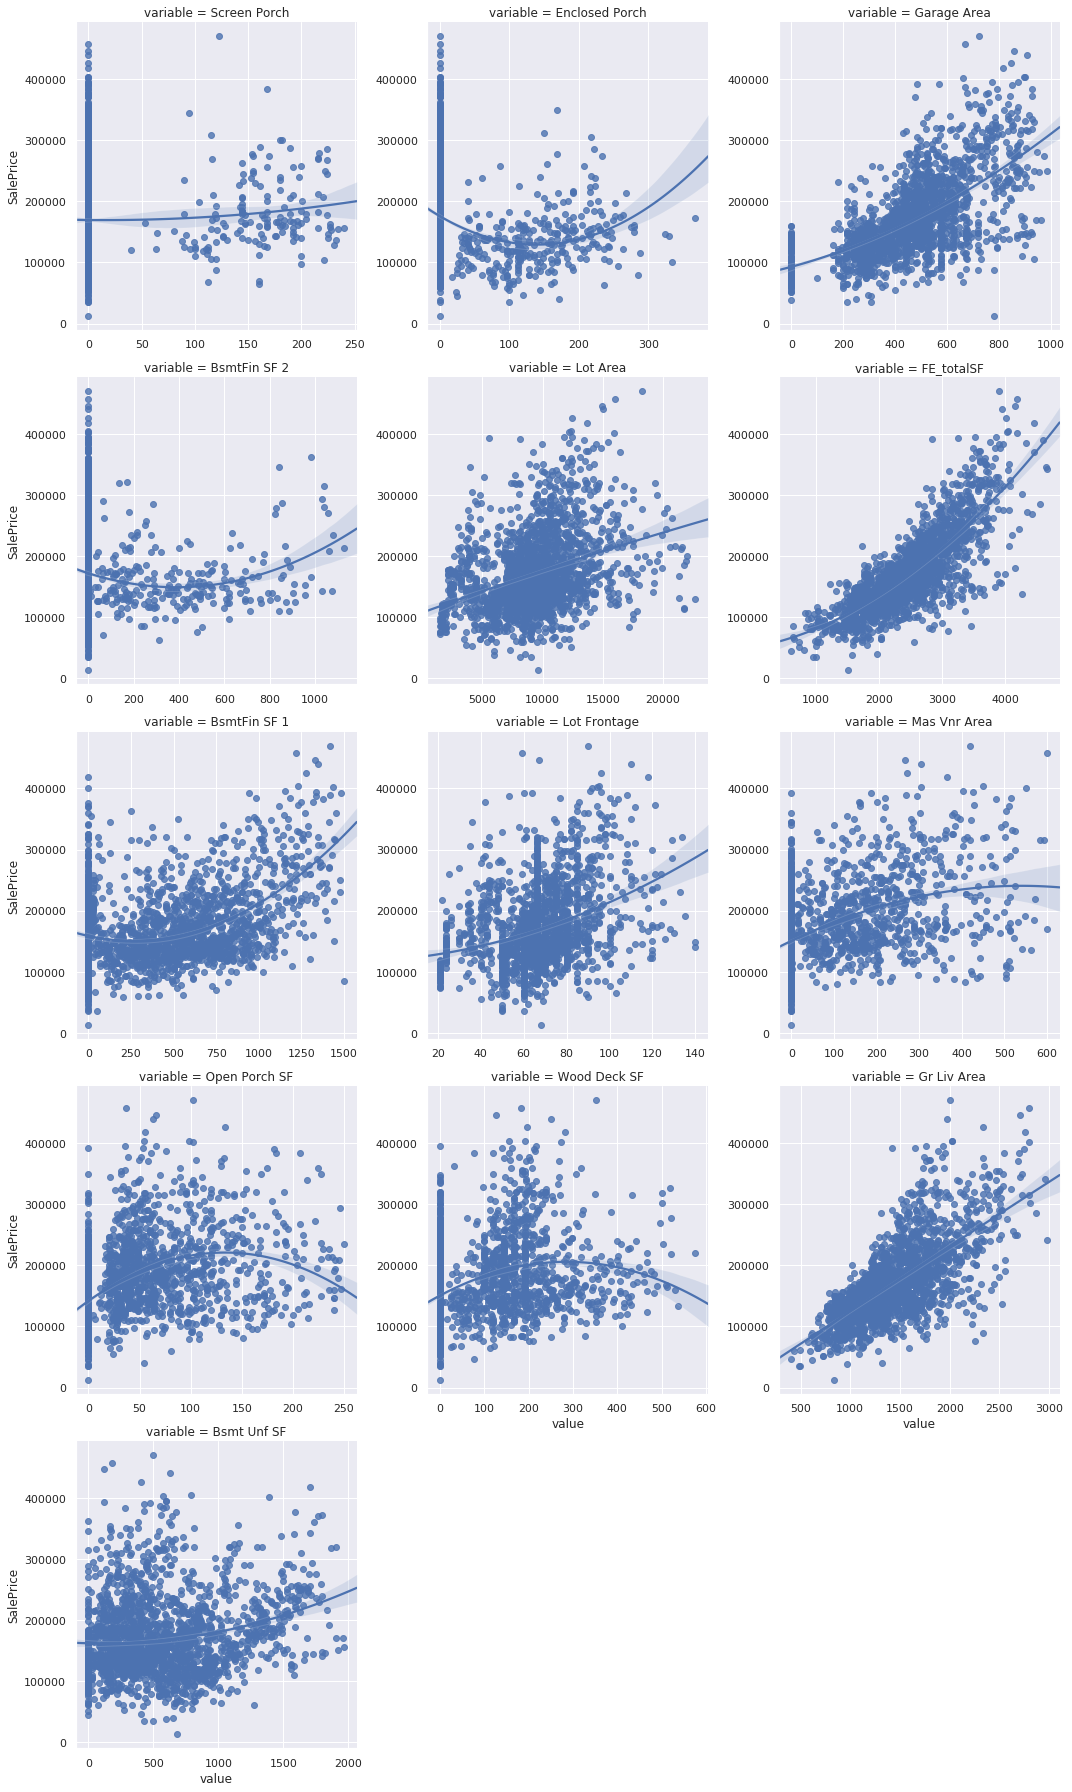

In [43]:
sns.FacetGrid(pd.melt(transformData(data), id_vars=['SalePrice'], value_vars=set(numeric)-set(['SalePrice'])), col="variable",  col_wrap=3, sharex=False, sharey=False, size=5).map(sns.regplot, "value", "SalePrice", order=2);

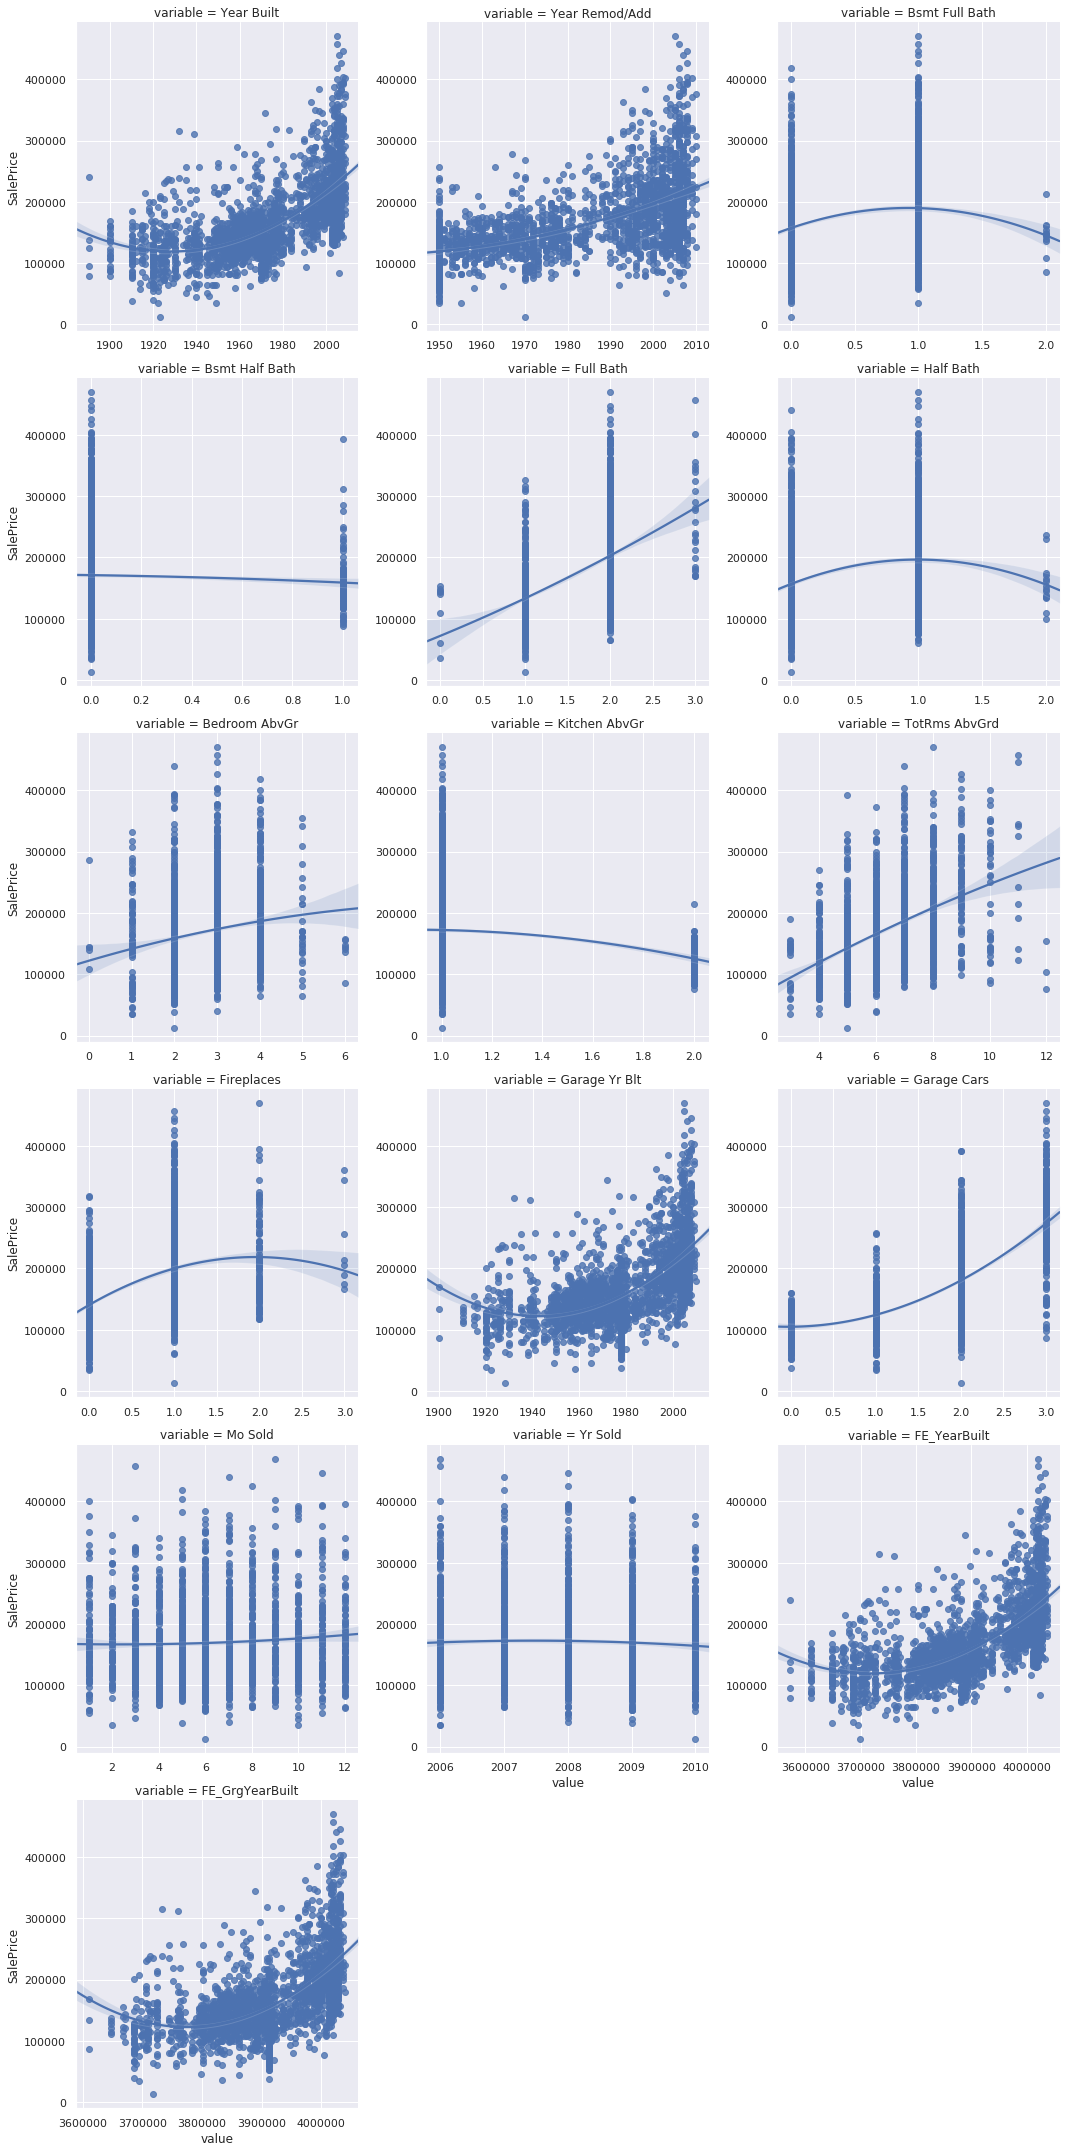

In [44]:
import warnings
warnings.filterwarnings('ignore')
sns.FacetGrid(pd.melt(transformData(data), id_vars=['SalePrice'], value_vars=discrete), col="variable",  col_wrap=3, sharex=False, sharey=False, size=5).map(sns.regplot, "value", "SalePrice",order=2);

For the simple model, we will choose 3 of these best variables for each category :
- FE_totalSF
- Garage Cars
- Bsmt Qual

But, before begining model training and testing, we will prepare function and training sets for the rest of this study because it will be used by all of the next sections.
### preparations for model fitting

For training data, we will devide it to training and test sets.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns.difference(['SalePrice'])], data['SalePrice'], test_size=0.2, random_state=0)

In this study, we will compare performance of many algorithms (Linear regression, huber regression, ridge regression and lasso) in combinaison with many scalers (Standard, MinMax and YeoJohnson).
Each algroithm will be tested with regularization and many hyperparameter values. We will all test applying log transformation on target variable.

To see if all these algorithms are useful, we will include a simple baseline model (no model) which always returns the median value for each perediction.

Here is some useful functions that we will use in our study. 

In [46]:
# This transformer class will apply the transformation function on a dataset
# and returns a subset of columns
class PandasTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, preprocess_f, cols=None):
        self.preprocess_f = preprocess_f
        self.cols = cols
    def fit(self, X, y=None):
        # Check that we get a DataFrame
        assert type(X) == pd.DataFrame
        if type(self.cols) == type(None):
            self.cols = self.preprocess_f(X).columns
        return self
    def transform(self, X):
        # Check that we get a DataFrame
        assert type(X) == pd.DataFrame
        # Preprocess data
        return self.preprocess_f(X)[self.cols]
    def get_feature_names(self):
        return self.cols
ordinal=['Lot Shape','Land Slope','FE_Overall','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond',
         'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Kitchen Qual','Functional','Fireplace Qu','Garage Finish',
         'Garage Qual','Garage Cond','Paved Drive','Electrical']
numeric = ['FE_totalSF', 'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Enclosed Porch', 'Garage Area', 'Gr Liv Area', 'Lot Area',
           'Lot Frontage',  'Mas Vnr Area', 'Open Porch SF',  'SalePrice', 'Screen Porch', 'Wood Deck SF']
categorical=['MS SubClass','MS Zoning','Land Contour','Lot Config','Neighborhood','Bldg Type',
             'House Style','Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air',
             'Garage Type','Misc Feature','Sale Type','Sale Condition','FE_Condition']
discrete=['Year Built','Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Yr Blt',
          'Garage Cars','Mo Sold','Yr Sold', 'FE_YearBuilt', 'FE_GrgYearBuilt']
all_cat_cols = list(set(categorical+ordinal)-set(['Street','Central Air']))
all_num_cols = list(set(numeric)-set(['SalePrice']))

# models, transformers, scalers and parameters
identity_transformer = FunctionTransformer(validate=True)
models = [ 
            ('BS', DummyRegressor(strategy="median")), # base model
            ('LR', LinearRegression()),
            ('HB', HuberRegressor()),
            ('RD', Ridge()),
            ('LS', Lasso(random_state=0)),
            ('LR_LOG', TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp)),
            ('HB_LOG', TransformedTargetRegressor(regressor=HuberRegressor(), func=np.log, inverse_func=np.exp)),
            ('RD_LOG', TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp)),
            ('LS_LOG', TransformedTargetRegressor(regressor=Lasso(random_state=0), func=np.log, inverse_func=np.exp))
         ]
scalers = [
            ('NoScaler', identity_transformer),
            ('StandardScaler', StandardScaler()),
            ('MinMaxScaler', MinMaxScaler()),
            ('YeoJohnson', PowerTransformer(method='yeo-johnson', standardize=True))
          ]
parameters = {'HB' : {'HB__alpha': np.logspace(-6, 5, num=12) },
              'RD' : {'RD__alpha': np.logspace(-6, 5, num=12) },
              'LS' : {'LS__alpha': np.logspace(-6, 5, num=12) },
              'LR' : { },
              'BS' : { },
              'HB_LOG' : {'HB_LOG__regressor__alpha': np.logspace(-6, 5, num=12) },
              'RD_LOG' : {'RD_LOG__regressor__alpha':  np.logspace(-6, 5, num=12) },
              'LS_LOG' : {'LS_LOG__regressor__alpha': np.logspace(-6, 5, num=12)},
              'LR_LOG' : { }
             }

def get_pipeline(model, scaler, parameters=parameters,cols=None):
    if type(cols) == type(None):
        num_cols = all_num_cols
        cat_cols = all_cat_cols
    else:
        num_cols = list(set(cols).intersection(set(all_num_cols)))
        cat_cols = list(set(cols).intersection(set(all_cat_cols)))
    pandas_transformer = PandasTransformer(transformData,cols)
    scale_transformer = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols) ,(scaler[0],  scaler[1], num_cols) ], remainder='passthrough')
    return Pipeline(steps=
                                     [('pandas',pandas_transformer),
                                      (scaler[0], scale_transformer),
                                       model
                                     ]
                              )
def get_cv(model, scaler,cols=None, parameters=parameters):
    print(f'model: {model[0]} scaler: {scaler[0]}')
    model_pipeline = get_pipeline(model, scaler, parameters,cols)
    np.random.seed(0)
    clf = GridSearchCV(model_pipeline, cv=5, param_grid=parameters[model[0]], iid=False, scoring='neg_mean_absolute_error')
    clf.fit(X_train, y_train)
    return clf
def run_one_model(model, scaler,cols=None, parameters=parameters):
    clf = get_cv(model, scaler,cols=cols, parameters=parameters)
    best  =  clf.best_params_
    best_mean = clf.cv_results_['mean_test_score'][clf.best_index_]
    best_std = clf.cv_results_['std_test_score'][clf.best_index_]
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    return (model[0], scaler[0], str(best), abs(best_mean), best_std, abs(train_score), abs(test_score))

def run_grid(cols=None):
    # We use parallelism with 36 processes to get results quickly
    with Pool(36) as pool:
       result = pool.starmap(run_one_model, [ ((model[0], clone(model[1])), (scaler[0], clone(scaler[1])),cols ) for scaler in scalers for model in models] )
    return pd.DataFrame(result, columns=['model','scaler','best_params','best_train_score_mean','best_train_score_std','train_score','test_score'])
def get_models_results(cols=None):
    results = run_grid(cols=cols)
    results['best_params'] = results['best_params'].apply(str)
    results['m']=results['model']+'-'+results['scaler']+'-'+results['best_params']
    results.set_index('m', inplace=True)
    results.sort_values('test_score', ascending=False).plot(kind='barh',y=['test_score','train_score'],figsize=(20,20));
    return results.sort_values('test_score')
def get_validation_curve_data(model, scaler,cols=None, parameters=parameters, score='MAE'):
    print(f'model: {model[0]} scaler: {scaler[0]}')
    if score=='MAE':
        scorer='neg_mean_absolute_error'
    else:
        scorer='neg_mean_squared_error'
    
    clf = get_pipeline(model, scaler, parameters,cols)
    param_grid=parameters[model[0]]
    np.random.seed(0)
    for param_name, param_range in param_grid.items():
        train_scores, test_scores = validation_curve(
            clf, X_train, y_train, param_name=param_name, param_range=param_range,cv=5,
            scoring=scorer)
        train_scores = np.abs(train_scores)
        test_scores = np.abs(test_scores)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        return (model,scaler,param_name,param_range,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std)
    return None
def plot_validation_curve_from_data(values):
        if values == None:
            return
        model,scaler,param_name,param_range,train_scores_mean,train_scores_std,test_scores_mean,test_scores_std = values
        plt.title(f"Validation Curve {model[0]}/{scaler[0]}")
        plt.xlabel(f"{param_name}")
        plt.ylabel("Score")
        plt.semilogx(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=2)
        plt.fill_between(param_range, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.2,
                         color="darkorange", lw=2)
        plt.semilogx(param_range, test_scores_mean, label="Test score",
                     color="navy", lw=2)
        plt.fill_between(param_range, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.2,
                         color="navy", lw=2)
        plt.legend(loc="best")
        plt.show()
def plot_validation_curve(model, scaler, cols=None,parameters=parameters, score='MAE'):
    plot_validation_curve_from_data(get_validation_curve_data(model, scaler,cols, parameters=parameters, score='MAE'))
def run_plot_validation_curve(score='MAE'):
    with Pool(16) as pool:
       result = pool.starmap(get_validation_curve_data, [ ((model[0], clone(model[1])), (scaler[0], clone(scaler[1])) ) for scaler in scalers for model in models] )
    for values in result:
        plot_validation_curve_from_data(values)

In this section, we will study the simple model.

The followning table gives performance results for each combinaison model/scaler for the simple model.

model: RD scaler: NoScaler
model: LS scaler: NoScaler
model: LR scaler: NoScaler
model: BS scaler: NoScaler
model: HB scaler: NoScaler
model: LR_LOG scaler: NoScaler
model: HB_LOG scaler: NoScaler
model: RD_LOG scaler: NoScaler
model: BS scaler: StandardScaler
model: LS_LOG scaler: NoScaler
model: RD scaler: StandardScaler
model: HB scaler: StandardScaler
model: LS scaler: StandardScaler
model: LR scaler: StandardScaler
model: LR_LOG scaler: StandardScaler
model: RD_LOG scaler: StandardScaler
model: HB_LOG scaler: StandardScaler
model: BS scaler: MinMaxScaler
model: LS_LOG scaler: StandardScaler
model: LR scaler: MinMaxScaler
model: HB scaler: MinMaxScaler
model: RD scaler: MinMaxScaler
model: LS scaler: MinMaxScaler
model: LR_LOG scaler: MinMaxScaler
model: HB_LOG scaler: MinMaxScaler
model: RD_LOG scaler: MinMaxScaler
model: RD scaler: YeoJohnson
model: BS scaler: YeoJohnson
model: LS_LOG scaler: MinMaxScaler
model: LR scaler: YeoJohnson
model: HB scaler: YeoJohnson
model: LR_LOG sca

model          scaler  \
m                                                                            
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  HB_LOG    MinMaxScaler   
HB_LOG-YeoJohnson-{'HB_LOG__regressor__alpha': ...  HB_LOG      YeoJohnson   
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...  HB_LOG  StandardScaler   
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  RD_LOG    MinMaxScaler   
LR_LOG-NoScaler-{}                                  LR_LOG        NoScaler   
RD_LOG-StandardScaler-{'RD_LOG__regressor__alph...  RD_LOG  StandardScaler   
RD_LOG-NoScaler-{'RD_LOG__regressor__alpha': 1e...  RD_LOG        NoScaler   
LS_LOG-StandardScaler-{'LS_LOG__regressor__alph...  LS_LOG  StandardScaler   
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  LS_LOG        NoScaler   
LS_LOG-MinMaxScaler-{'LS_LOG__regressor__alpha'...  LS_LOG    MinMaxScaler   
LR_LOG-YeoJohnson-{}                                LR_LOG      YeoJohnson   
LS_LOG-YeoJohnson-{'LS_LOG__regressor__alpha': ...  LS_LOG      YeoJohnson   
RD_LOG-YeoJohnson-{'RD_LOG__regressor__alpha': ...  RD_LOG      YeoJohnson   
LR_LOG-MinMaxScaler-{}                              LR_LOG    MinMaxScaler   
LR_LOG-StandardScaler-{}                            LR_LOG  StandardScaler   
LR-MinMaxScaler-{}                                      LR    MinMaxScaler   
HB-MinMaxScaler-{'HB__alpha': 1e-05}                    HB    MinMaxScaler   
RD-MinMaxScaler-{'RD__alpha': 1.0}                      RD    MinMaxScaler   
HB-StandardScaler-{'HB__alpha': 1e-05}                  HB  StandardScaler   
LR-StandardScaler-{}                                    LR  StandardScaler   
LR-NoScaler-{}                                          LR        NoScaler   
RD-StandardScaler-{'RD__alpha': 1e-06}                  RD  StandardScaler   
RD-NoScaler-{'RD__alpha': 1e-06}                        RD        NoScaler   
LS-StandardScaler-{'LS__alpha': 10.0}                   LS  StandardScaler   
LS-NoScaler-{'LS__alpha': 10.0}                         LS        NoScaler   
LS-MinMaxScaler-{'LS__alpha': 100.0}                    LS    MinMaxScaler   
HB-YeoJohnson-{'HB__alpha': 1e-06}                      HB      YeoJohnson   
LR-YeoJohnson-{}                                        LR      YeoJohnson   
LS-YeoJohnson-{'LS__alpha': 1e-06}                      LS      YeoJohnson   
RD-YeoJohnson-{'RD__alpha': 1e-06}                      RD      YeoJohnson   
HB-NoScaler-{'HB__alpha': 1e-05}                        HB        NoScaler   
HB_LOG-NoScaler-{'HB_LOG__regressor__alpha': 10...  HB_LOG        NoScaler   
BS-StandardScaler-{}                                    BS  StandardScaler   
BS-YeoJohnson-{}                                        BS      YeoJohnson   
BS-MinMaxScaler-{}                                      BS    MinMaxScaler   
BS-NoScaler-{}                                          BS        NoScaler   

                                                                             best_params  \
m                                                                                          
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...    {'HB_LOG__regressor__alpha': 10.0}   
HB_LOG-YeoJohnson-{'HB_LOG__regressor__alpha': ...   {'HB_LOG__regressor__alpha': 1e-05}   
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...    {'HB_LOG__regressor__alpha': 0.01}   
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...     {'RD_LOG__regressor__alpha': 1.0}   
LR_LOG-NoScaler-{}                                                                    {}   
RD_LOG-StandardScaler-{'RD_LOG__regressor__alph...   {'RD_LOG__regressor__alpha': 1e-06}   
RD_LOG-NoScaler-{'RD_LOG__regressor__alpha': 1e...   {'RD_LOG__regressor__alpha': 1e-06}   
LS_LOG-StandardScaler-{'LS_LOG__regressor__alph...   {'LS_LOG__regressor__alpha': 1e-06}   
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...   {'LS_LOG__regressor__alpha': 1e-06}   
LS_LOG-MinMaxScaler-{'LS_LOG__regressor__alpha'...   {'LS_LOG__regressor__al

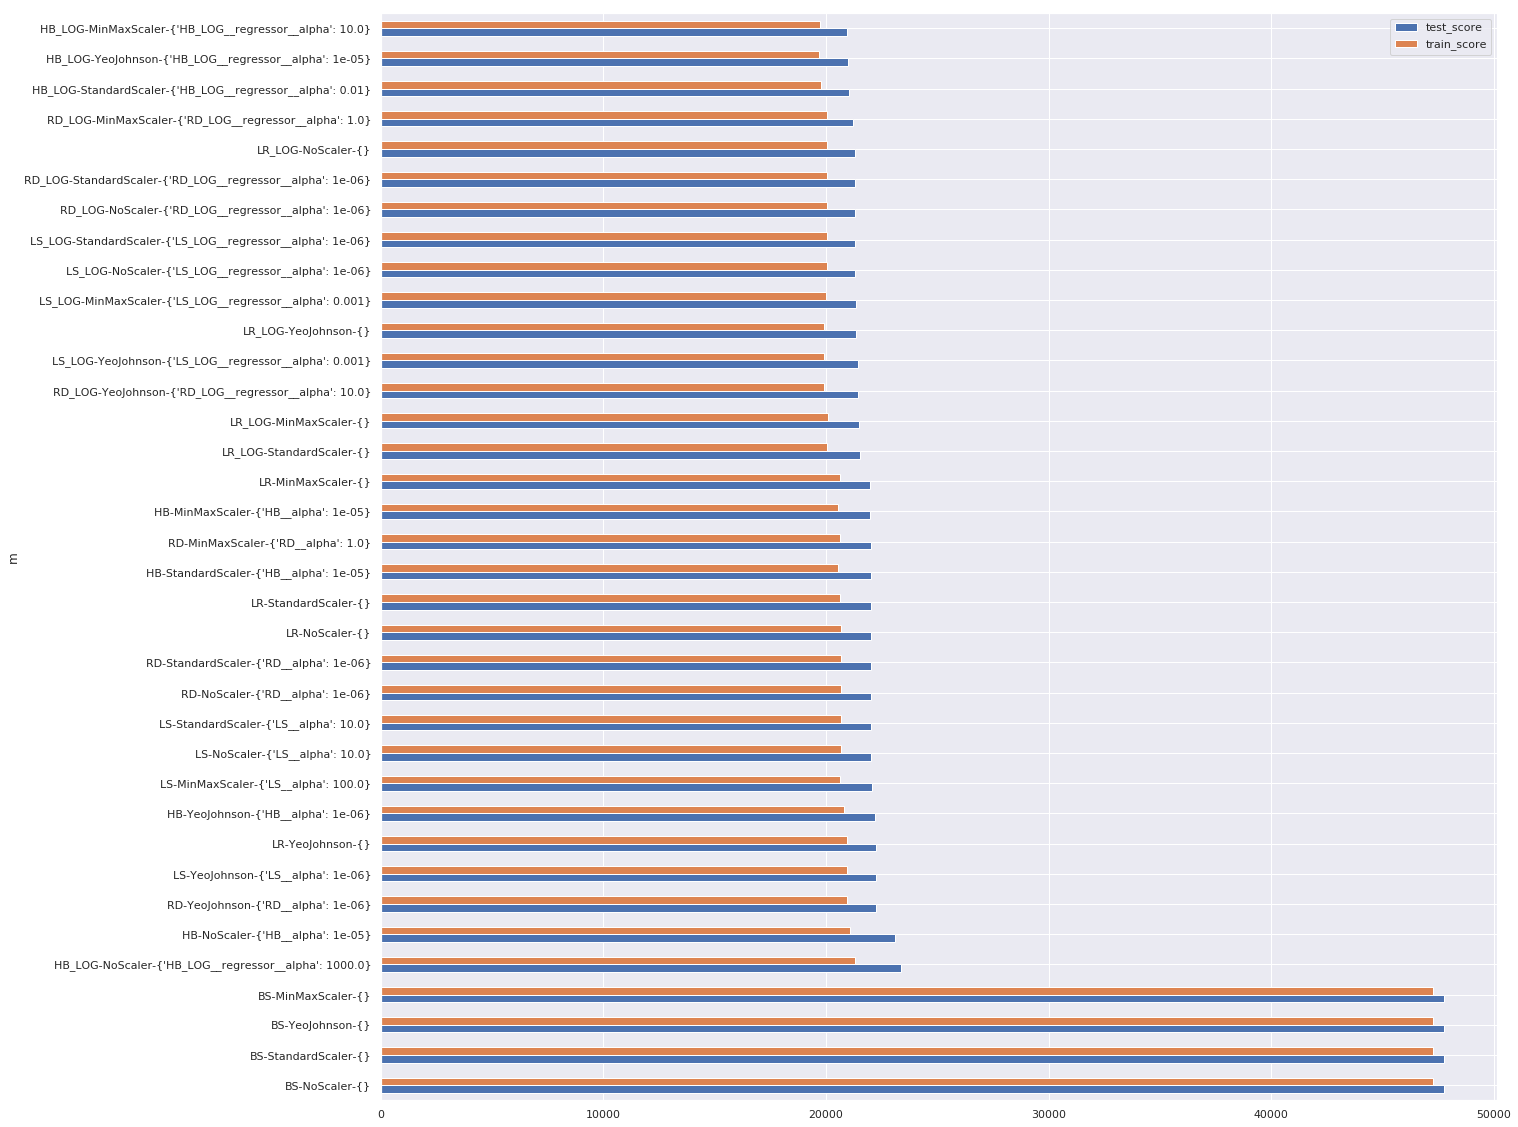

In [47]:
results_simple_model = get_models_results(cols=['FE_totalSF','Garage Cars','Bsmt Qual'])
results_simple_model

The algorithm that gives better performance for this simple model is the Huber Regressor combined with data scaling (all scalers are almost equivalent) and with appling log fuction on target variable.

This algorithm gives much better results than the base model.

This best algorithm is much better (MAE=$20936$ $dollars$) than the baseline (MAE=$47737$ $dollars$).

Lets see learning curve of some of these algorithms :

model: HB_LOG scaler: StandardScaler


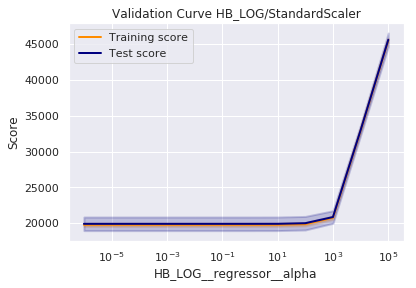

model: RD_LOG scaler: StandardScaler


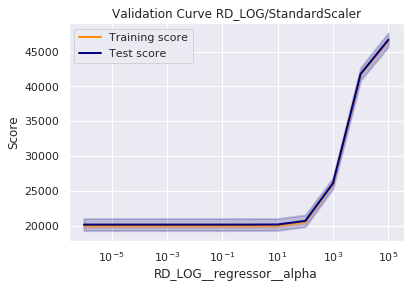

model: LS_LOG scaler: StandardScaler


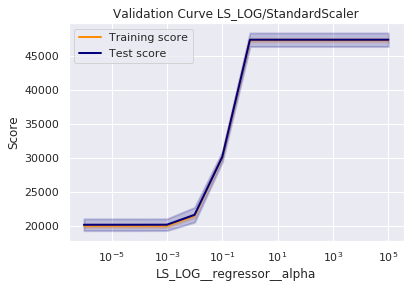

In [48]:
plot_validation_curve(models[6], scalers[1], cols=['FE_totalSF','Garage Cars','Bsmt Qual'])
plot_validation_curve(models[7], scalers[1], cols=['FE_totalSF','Garage Cars','Bsmt Qual'])
plot_validation_curve(models[8], scalers[1], cols=['FE_totalSF','Garage Cars','Bsmt Qual'])

- Huber regressor gives best results with parameter alpha <= $10$.
- Rigde regressor gives best results with parameter alpha <= $10$.
- Lasso regressor gives best results with parameter alpha <= $10^{-3}$

#### selecting best columns with selectKbest

Many methods to select variables are available like selectKbest and RFE .... 

We will use SelectKbest method to select 3 features for our simple model.

The following table gives the best 10 features selected by selectKbest :

In [49]:
select_feature = SelectKBest(f_regression, k=10).fit(transformData(X_train), y_train)
selected_features_df = pd.DataFrame({'Feature':list(transformData(X_train).columns),'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)[:10]

Feature       Scores
57   Overall Qual  3335.251901
72     FE_totalSF  3263.517320
35    Gr Liv Area  1705.685137
20     Exter Qual  1619.601983
29    Garage Cars  1361.844070
41   Kitchen Qual  1348.923867
28    Garage Area  1143.583224
73   FE_YearBuilt  1093.727122
67     Year Built  1082.279136
65  Total Bsmt SF   991.531185

We will compute performance of our models using the top 3 columns selected by selectKbest :

model: LS scaler: NoScaler
model: LR scaler: NoScaler
model: RD scaler: NoScaler
model: HB scaler: NoScaler
model: BS scaler: NoScaler
model: LR_LOG scaler: NoScaler
model: HB_LOG scaler: NoScaler
model: RD_LOG scaler: NoScaler
model: BS scaler: StandardScaler
model: LS_LOG scaler: NoScaler
model: LS scaler: StandardScaler
model: LR scaler: StandardScaler
model: RD scaler: StandardScaler
model: HB scaler: StandardScaler
model: LR_LOG scaler: StandardScaler
model: HB_LOG scaler: StandardScaler
model: RD_LOG scaler: StandardScaler
model: HB scaler: MinMaxScaler
model: LR scaler: MinMaxScaler
model: LS_LOG scaler: StandardScaler
model: LR_LOG scaler: MinMaxScaler
model: BS scaler: MinMaxScaler
model: RD scaler: MinMaxScaler
model: LS scaler: MinMaxScaler
model: HB_LOG scaler: MinMaxScaler
model: RD_LOG scaler: MinMaxScaler
model: LS_LOG scaler: MinMaxScaler
model: RD scaler: YeoJohnson
model: LR scaler: YeoJohnson
model: BS scaler: YeoJohnson
model: LS scaler: YeoJohnson
model: HB scaler:

model          scaler  \
m                                                                            
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...  HB_LOG  StandardScaler   
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  HB_LOG    MinMaxScaler   
HB_LOG-NoScaler-{'HB_LOG__regressor__alpha': 1e...  HB_LOG        NoScaler   
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  RD_LOG    MinMaxScaler   
RD_LOG-StandardScaler-{'RD_LOG__regressor__alph...  RD_LOG  StandardScaler   
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....  LS_LOG        NoScaler   
RD_LOG-NoScaler-{'RD_LOG__regressor__alpha': 10.0}  RD_LOG        NoScaler   
LS_LOG-StandardScaler-{'LS_LOG__regressor__alph...  LS_LOG  StandardScaler   
LR_LOG-MinMaxScaler-{}                              LR_LOG    MinMaxScaler   
LR_LOG-StandardScaler-{}                            LR_LOG  StandardScaler   
LR_LOG-NoScaler-{}                                  LR_LOG        NoScaler   
LS_LOG-MinMaxScaler-{'LS_LOG__regressor__alpha'...  LS_LOG    MinMaxScaler   
HB_LOG-YeoJohnson-{'HB_LOG__regressor__alpha': ...  HB_LOG      YeoJohnson   
RD_LOG-YeoJohnson-{'RD_LOG__regressor__alpha': ...  RD_LOG      YeoJohnson   
LR_LOG-YeoJohnson-{}                                LR_LOG      YeoJohnson   
LS_LOG-YeoJohnson-{'LS_LOG__regressor__alpha': ...  LS_LOG      YeoJohnson   
HB-StandardScaler-{'HB__alpha': 0.001}                  HB  StandardScaler   
HB-MinMaxScaler-{'HB__alpha': 1e-05}                    HB    MinMaxScaler   
HB-NoScaler-{'HB__alpha': 0.001}                        HB        NoScaler   
RD-StandardScaler-{'RD__alpha': 100.0}                  RD  StandardScaler   
LS-StandardScaler-{'LS__alpha': 1000.0}                 LS  StandardScaler   
RD-MinMaxScaler-{'RD__alpha': 1.0}                      RD    MinMaxScaler   
LS-MinMaxScaler-{'LS__alpha': 100.0}                    LS    MinMaxScaler   
LS-NoScaler-{'LS__alpha': 1000.0}                       LS        NoScaler   
LR-StandardScaler-{}                                    LR  StandardScaler   
LR-MinMaxScaler-{}                                      LR    MinMaxScaler   
LR-NoScaler-{}                                          LR        NoScaler   
RD-NoScaler-{'RD__alpha': 100.0}                        RD        NoScaler   
HB-YeoJohnson-{'HB__alpha': 0.001}                      HB      YeoJohnson   
LS-YeoJohnson-{'LS__alpha': 1000.0}                     LS      YeoJohnson   
RD-YeoJohnson-{'RD__alpha': 100.0}                      RD      YeoJohnson   
LR-YeoJohnson-{}                                        LR      YeoJohnson   
BS-StandardScaler-{}                                    BS  StandardScaler   
BS-YeoJohnson-{}                                        BS      YeoJohnson   
BS-MinMaxScaler-{}                                      BS    MinMaxScaler   
BS-NoScaler-{}                                          BS        NoScaler   

                                                                            best_params  \
m                                                                                         
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...  {'HB_LOG__regressor__alpha': 100.0}   
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...    {'HB_LOG__regressor__alpha': 1.0}   
HB_LOG-NoScaler-{'HB_LOG__regressor__alpha': 1e...  {'HB_LOG__regressor__alpha': 1e-05}   
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...    {'RD_LOG__regressor__alpha': 1.0}   
RD_LOG-StandardScaler-{'RD_LOG__regressor__alph...   {'RD_LOG__regressor__alpha': 10.0}   
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....  {'LS_LOG__regressor__alpha': 0.001}   
RD_LOG-NoScaler-{'RD_LOG__regressor__alpha': 10.0}   {'RD_LOG__regressor__alpha': 10.0}   
LS_LOG-StandardScaler-{'LS_LOG__regressor__alph...  {'LS_LOG__regressor__alpha': 0.001}   
LR_LOG-MinMaxScaler-{}                                                               {}   
LR_LOG-StandardScaler-{}                                                             {}

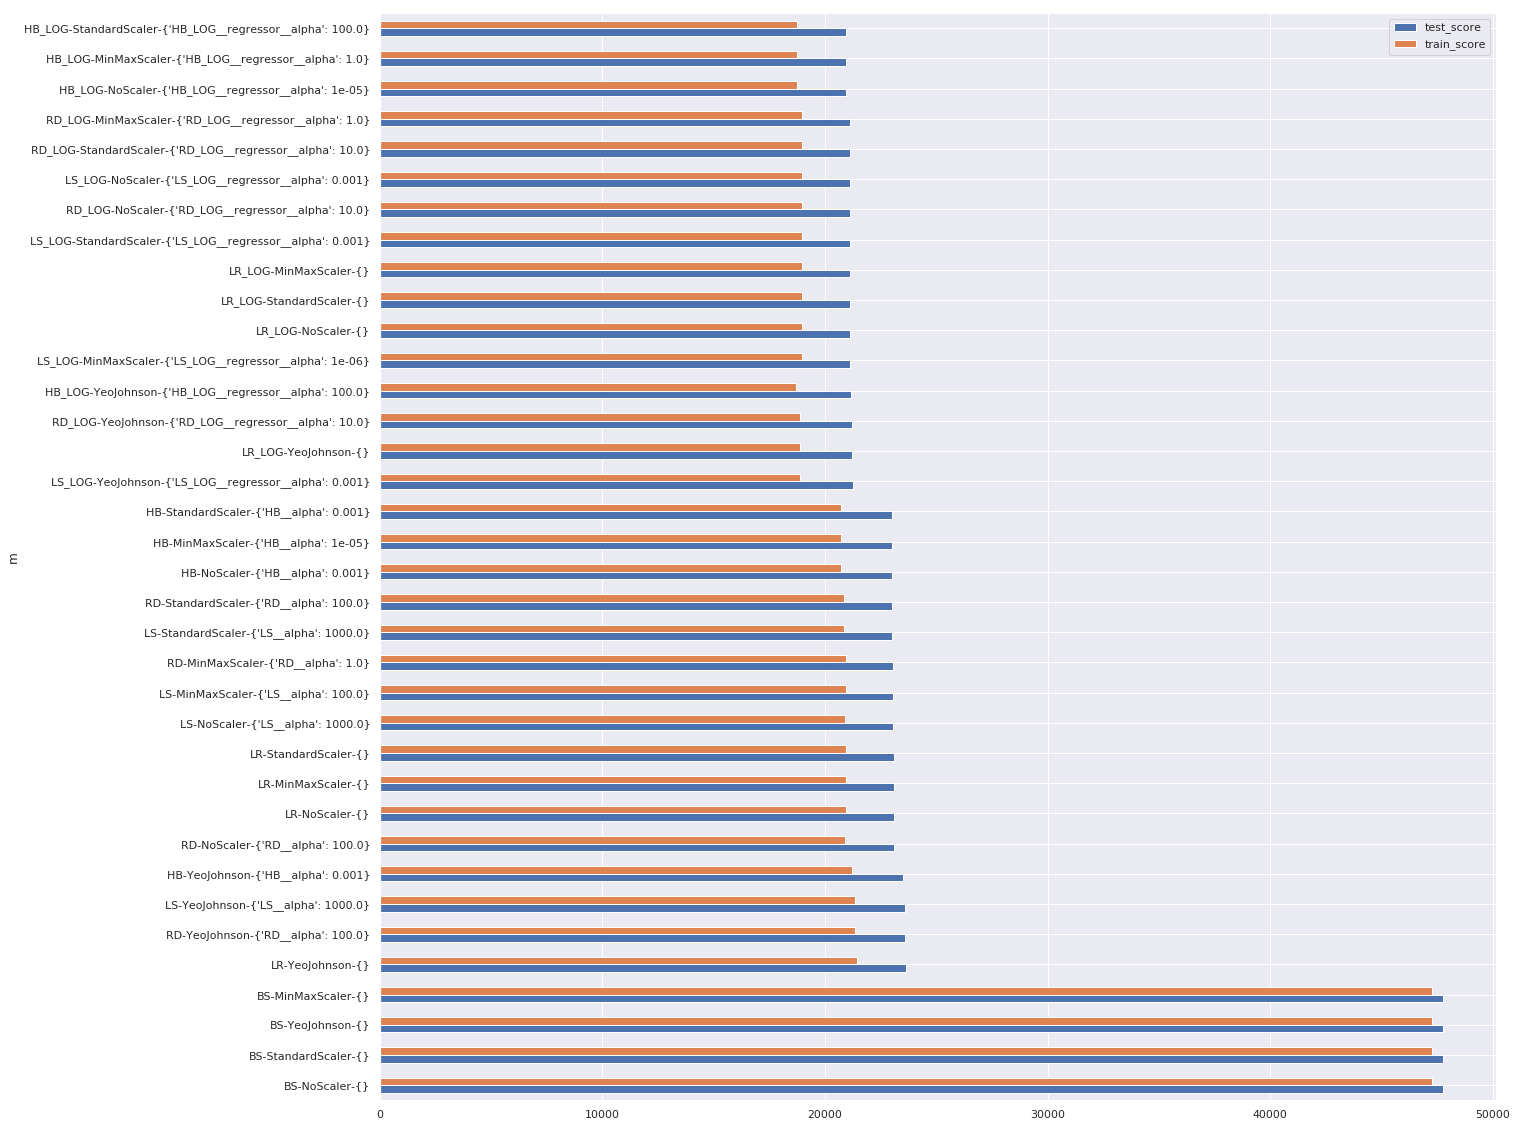

In [50]:
results_simple_model_2 = get_models_results(cols=['Overall Qual','FE_totalSF','Gr Liv Area'])
results_simple_model_2

In [51]:
print('Best Model for manual method base on correlation :')
results_simple_model.head(1)

Best Model for manual method base on correlation :


model        scaler  \
m                                                                          
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  HB_LOG  MinMaxScaler   

                                                                           best_params  \
m                                                                                        
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  {'HB_LOG__regressor__alpha': 10.0}   

                                                    best_train_score_mean  \
m                                                                           
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...           19868.294739   

                                                    best_train_score_std  \
m                                                                          
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...            888.819835   

                                                     train_score    test_score  
m                                                                               
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  19739.549646  20936.409869

In [52]:
print('Best Model for manual method base on selectKbest :')
results_simple_model_2.head(1)

Best Model for manual method base on selectKbest :


model          scaler  \
m                                                                            
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...  HB_LOG  StandardScaler   

                                                                            best_params  \
m                                                                                         
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...  {'HB_LOG__regressor__alpha': 100.0}   

                                                    best_train_score_mean  \
m                                                                           
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...            18797.74862   

                                                    best_train_score_std  \
m                                                                          
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...            869.937554   

                                                     train_score    test_score  
m                                                                               
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...  18754.957893  20930.720924

Performance (MAE) are almost the same for manual method and automatic method using selectKbest.

## Intermediate model

### Using SelectKbest :
In order to select variables for intermediate model, we can use the selectKbest method as it's almost equivalent to manual method based on correlation matrices.

In [53]:
selected_features_df.sort_values(by='Scores', ascending=False)[:10].Feature.to_list()

['Overall Qual',
 'FE_totalSF',
 'Gr Liv Area',
 'Exter Qual',
 'Garage Cars',
 'Kitchen Qual',
 'Garage Area',
 'FE_YearBuilt',
 'Year Built',
 'Total Bsmt SF']

model: BS scaler: NoScaler
model: HB scaler: NoScaler
model: RD scaler: NoScaler
model: LR scaler: NoScaler
model: LS scaler: NoScaler
model: LR_LOG scaler: NoScaler
model: HB_LOG scaler: NoScaler
model: RD_LOG scaler: NoScaler
model: LS_LOG scaler: NoScaler
model: LR scaler: StandardScaler
model: BS scaler: StandardScaler
model: LS scaler: StandardScaler
model: RD scaler: StandardScaler
model: HB scaler: StandardScaler
model: LR_LOG scaler: StandardScaler
model: HB_LOG scaler: StandardScaler
model: RD_LOG scaler: StandardScaler
model: HB scaler: MinMaxScaler
model: LS_LOG scaler: StandardScaler
model: LR scaler: MinMaxScaler
model: LS scaler: MinMaxScaler
model: LR_LOG scaler: MinMaxScaler
model: BS scaler: MinMaxScaler
model: RD scaler: MinMaxScaler
model: HB_LOG scaler: MinMaxScaler
model: RD_LOG scaler: MinMaxScaler
model: RD scaler: YeoJohnson
model: LR scaler: YeoJohnson
model: BS scaler: YeoJohnson
model: HB scaler: YeoJohnson
model: LS_LOG scaler: MinMaxScaler
model: LS scaler:

model          scaler  \
m                                                                            
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  LS_LOG        NoScaler   
LS_LOG-MinMaxScaler-{'LS_LOG__regressor__alpha'...  LS_LOG    MinMaxScaler   
LS_LOG-StandardScaler-{'LS_LOG__regressor__alph...  LS_LOG  StandardScaler   
LR_LOG-NoScaler-{}                                  LR_LOG        NoScaler   
LR_LOG-MinMaxScaler-{}                              LR_LOG    MinMaxScaler   
LR_LOG-StandardScaler-{}                            LR_LOG  StandardScaler   
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  RD_LOG    MinMaxScaler   
RD_LOG-StandardScaler-{'RD_LOG__regressor__alph...  RD_LOG  StandardScaler   
RD_LOG-NoScaler-{'RD_LOG__regressor__alpha': 10.0}  RD_LOG        NoScaler   
LS_LOG-YeoJohnson-{'LS_LOG__regressor__alpha': ...  LS_LOG      YeoJohnson   
LR_LOG-YeoJohnson-{}                                LR_LOG      YeoJohnson   
RD_LOG-YeoJohnson-{'RD_LOG__regressor__alpha': ...  RD_LOG      YeoJohnson   
RD-MinMaxScaler-{'RD__alpha': 1.0}                      RD    MinMaxScaler   
RD-StandardScaler-{'RD__alpha': 1.0}                    RD  StandardScaler   
LR-StandardScaler-{}                                    LR  StandardScaler   
LR-MinMaxScaler-{}                                      LR    MinMaxScaler   
LR-NoScaler-{}                                          LR        NoScaler   
RD-NoScaler-{'RD__alpha': 1e-06}                        RD        NoScaler   
LS-MinMaxScaler-{'LS__alpha': 10.0}                     LS    MinMaxScaler   
LS-StandardScaler-{'LS__alpha': 10.0}                   LS  StandardScaler   
LS-NoScaler-{'LS__alpha': 1e-06}                        LS        NoScaler   
LR-YeoJohnson-{}                                        LR      YeoJohnson   
RD-YeoJohnson-{'RD__alpha': 1e-06}                      RD      YeoJohnson   
LS-YeoJohnson-{'LS__alpha': 1e-06}                      LS      YeoJohnson   
HB-NoScaler-{'HB__alpha': 1e-06}                        HB        NoScaler   
HB_LOG-NoScaler-{'HB_LOG__regressor__alpha': 10...  HB_LOG        NoScaler   
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...  HB_LOG  StandardScaler   
HB_LOG-YeoJohnson-{'HB_LOG__regressor__alpha': ...  HB_LOG      YeoJohnson   
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  HB_LOG    MinMaxScaler   
HB-MinMaxScaler-{'HB__alpha': 100000.0}                 HB    MinMaxScaler   
HB-StandardScaler-{'HB__alpha': 100000.0}               HB  StandardScaler   
HB-YeoJohnson-{'HB__alpha': 100000.0}                   HB      YeoJohnson   
BS-YeoJohnson-{}                                        BS      YeoJohnson   
BS-StandardScaler-{}                                    BS  StandardScaler   
BS-MinMaxScaler-{}                                      BS    MinMaxScaler   
BS-NoScaler-{}                                          BS        NoScaler   

                                                                               best_params  \
m                                                                                            
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...     {'LS_LOG__regressor__alpha': 1e-06}   
LS_LOG-MinMaxScaler-{'LS_LOG__regressor__alpha'...     {'LS_LOG__regressor__alpha': 1e-05}   
LS_LOG-StandardScaler-{'LS_LOG__regressor__alph...     {'LS_LOG__regressor__alpha': 1e-05}   
LR_LOG-NoScaler-{}                                                                      {}   
LR_LOG-MinMaxScaler-{}                                                                  {}   
LR_LOG-StandardScaler-{}                                                                {}   
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...       {'RD_LOG__regressor__alpha': 1.0}   
RD_LOG-StandardScaler-{'RD_LOG__regressor__alph...      {'RD_LOG__regressor__alpha': 10.0}   
RD_LOG-NoScaler-{'RD_LOG__regressor__alpha': 10.0}      {'RD_LOG__regressor__alpha': 10.0}   
LS_LOG-YeoJohnson-{'LS_LOG__regressor__alpha': ...    

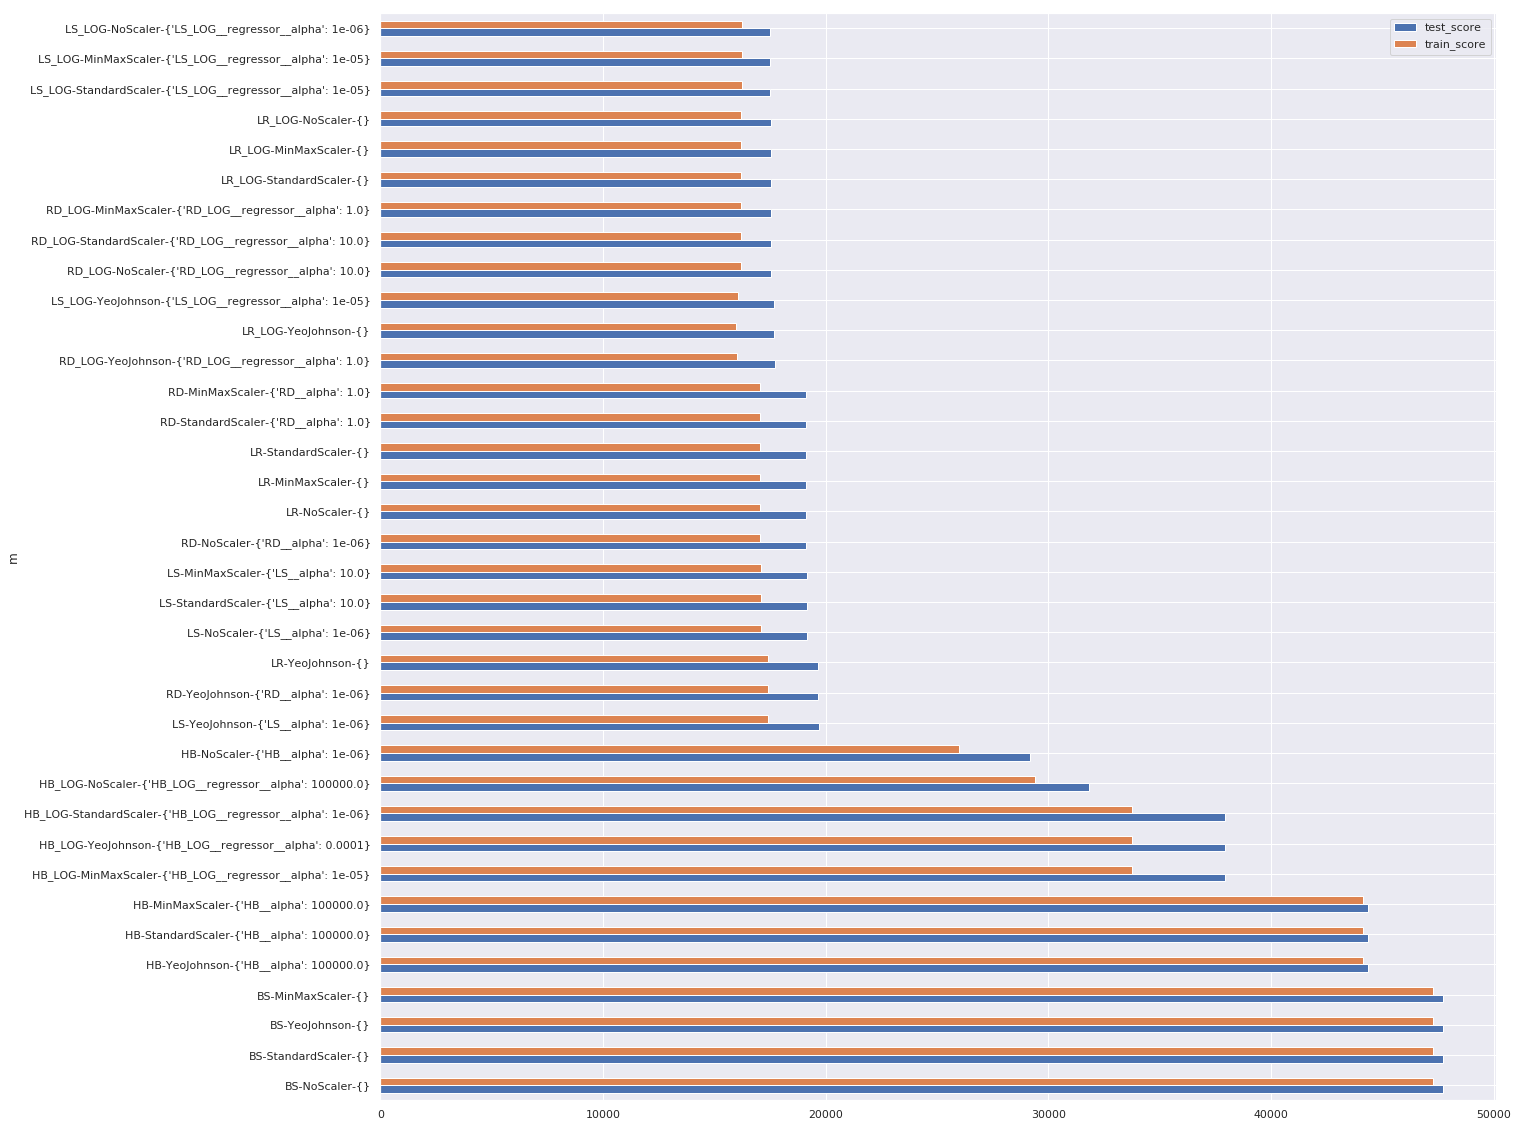

In [54]:
results_intermediate_model = get_models_results(cols=selected_features_df.sort_values(by='Scores', ascending=False)[:10].Feature.to_list())
results_intermediate_model

In [55]:
print('Best simple Model  :')
results_simple_model.head(1)

Best simple Model  :


model        scaler  \
m                                                                          
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  HB_LOG  MinMaxScaler   

                                                                           best_params  \
m                                                                                        
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  {'HB_LOG__regressor__alpha': 10.0}   

                                                    best_train_score_mean  \
m                                                                           
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...           19868.294739   

                                                    best_train_score_std  \
m                                                                          
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...            888.819835   

                                                     train_score    test_score  
m                                                                               
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  19739.549646  20936.409869

In [56]:
print('Best intermediate model :')
results_intermediate_model.head(1)

Best intermediate model :


model    scaler  \
m                                                                      
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  LS_LOG  NoScaler   

                                                                            best_params  \
m                                                                                         
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  {'LS_LOG__regressor__alpha': 1e-06}   

                                                    best_train_score_mean  \
m                                                                           
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...           16458.126464   

                                                    best_train_score_std  \
m                                                                          
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...            903.522431   

                                                     train_score    test_score  
m                                                                               
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  16251.288228  17482.145453

As we can see, using more features gives better performance results. **MAE** goes down from **20936 dollars** to **17482 dollars**


### Using PCA :

It's also possible to use Principal component analysis to reduce number of features.
We will add it to our pipeline and see the performance of new model.

model: BS scaler: NoScaler
model: LS scaler: NoScaler
model: LR scaler: NoScaler
model: RD scaler: NoScaler
model: HB scaler: NoScaler
model: LR_LOG scaler: NoScaler
model: HB_LOG scaler: NoScaler
model: RD_LOG scaler: NoScaler
model: LS_LOG scaler: NoScaler
model: RD scaler: StandardScaler
model: LR scaler: StandardScaler
model: HB scaler: StandardScaler
model: LS scaler: StandardScaler
model: BS scaler: StandardScaler
model: LR_LOG scaler: StandardScaler
model: HB_LOG scaler: StandardScaler
model: RD_LOG scaler: StandardScaler
model: BS scaler: MinMaxScaler
model: LS_LOG scaler: StandardScaler
model: RD scaler: MinMaxScaler
model: LR scaler: MinMaxScaler
model: HB scaler: MinMaxScaler
model: LR_LOG scaler: MinMaxScaler
model: LS scaler: MinMaxScaler
model: HB_LOG scaler: MinMaxScaler
model: RD_LOG scaler: MinMaxScaler
model: LS_LOG scaler: MinMaxScaler
model: BS scaler: YeoJohnson
model: LR scaler: YeoJohnson
model: RD scaler: YeoJohnson
model: LS scaler: YeoJohnson
model: HB scaler:

model          scaler  \
m                                                                            
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  RD_LOG    MinMaxScaler   
LS_LOG-MinMaxScaler-{'LS_LOG__regressor__alpha'...  LS_LOG    MinMaxScaler   
LR_LOG-MinMaxScaler-{}                              LR_LOG    MinMaxScaler   
LS_LOG-StandardScaler-{'LS_LOG__regressor__alph...  LS_LOG  StandardScaler   
LR_LOG-StandardScaler-{}                            LR_LOG  StandardScaler   
RD_LOG-StandardScaler-{'RD_LOG__regressor__alph...  RD_LOG  StandardScaler   
LR_LOG-NoScaler-{}                                  LR_LOG        NoScaler   
RD_LOG-NoScaler-{'RD_LOG__regressor__alpha': 1e...  RD_LOG        NoScaler   
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1.0}   LS_LOG        NoScaler   
LS_LOG-YeoJohnson-{'LS_LOG__regressor__alpha': ...  LS_LOG      YeoJohnson   
RD_LOG-YeoJohnson-{'RD_LOG__regressor__alpha': ...  RD_LOG      YeoJohnson   
LR_LOG-YeoJohnson-{}                                LR_LOG      YeoJohnson   
RD-MinMaxScaler-{'RD__alpha': 100.0}                    RD    MinMaxScaler   
LS-MinMaxScaler-{'LS__alpha': 1000.0}                   LS    MinMaxScaler   
LR-MinMaxScaler-{}                                      LR    MinMaxScaler   
LS-NoScaler-{'LS__alpha': 100000.0}                     LS        NoScaler   
RD-NoScaler-{'RD__alpha': 100000.0}                     RD        NoScaler   
LR-NoScaler-{}                                          LR        NoScaler   
LS-StandardScaler-{'LS__alpha': 1000.0}                 LS  StandardScaler   
RD-StandardScaler-{'RD__alpha': 1000.0}                 RD  StandardScaler   
LR-StandardScaler-{}                                    LR  StandardScaler   
LS-YeoJohnson-{'LS__alpha': 1000.0}                     LS      YeoJohnson   
RD-YeoJohnson-{'RD__alpha': 1000.0}                     RD      YeoJohnson   
LR-YeoJohnson-{}                                        LR      YeoJohnson   
HB_LOG-NoScaler-{'HB_LOG__regressor__alpha': 10...  HB_LOG        NoScaler   
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...  HB_LOG  StandardScaler   
HB_LOG-YeoJohnson-{'HB_LOG__regressor__alpha': ...  HB_LOG      YeoJohnson   
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  HB_LOG    MinMaxScaler   
HB-MinMaxScaler-{'HB__alpha': 100.0}                    HB    MinMaxScaler   
HB-StandardScaler-{'HB__alpha': 100.0}                  HB  StandardScaler   
HB-NoScaler-{'HB__alpha': 100.0}                        HB        NoScaler   
HB-YeoJohnson-{'HB__alpha': 100.0}                      HB      YeoJohnson   
BS-MinMaxScaler-{}                                      BS    MinMaxScaler   
BS-StandardScaler-{}                                    BS  StandardScaler   
BS-YeoJohnson-{}                                        BS      YeoJohnson   
BS-NoScaler-{}                                          BS        NoScaler   

                                                                               best_params  \
m                                                                                            
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...     {'RD_LOG__regressor__alpha': 100.0}   
LS_LOG-MinMaxScaler-{'LS_LOG__regressor__alpha'...      {'LS_LOG__regressor__alpha': 0.01}   
LR_LOG-MinMaxScaler-{}                                                                  {}   
LS_LOG-StandardScaler-{'LS_LOG__regressor__alph...      {'LS_LOG__regressor__alpha': 0.01}   
LR_LOG-StandardScaler-{}                                                                {}   
RD_LOG-StandardScaler-{'RD_LOG__regressor__alph...    {'RD_LOG__regressor__alpha': 1000.0}   
LR_LOG-NoScaler-{}                                                                      {}   
RD_LOG-NoScaler-{'RD_LOG__regressor__alpha': 1e...     {'RD_LOG__regressor__alpha': 1e-06}   
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1.0}        {'LS_LOG__regressor__alpha': 1.0}   
LS_LOG-YeoJohnson-{'LS_LOG__regressor__alpha': ...    

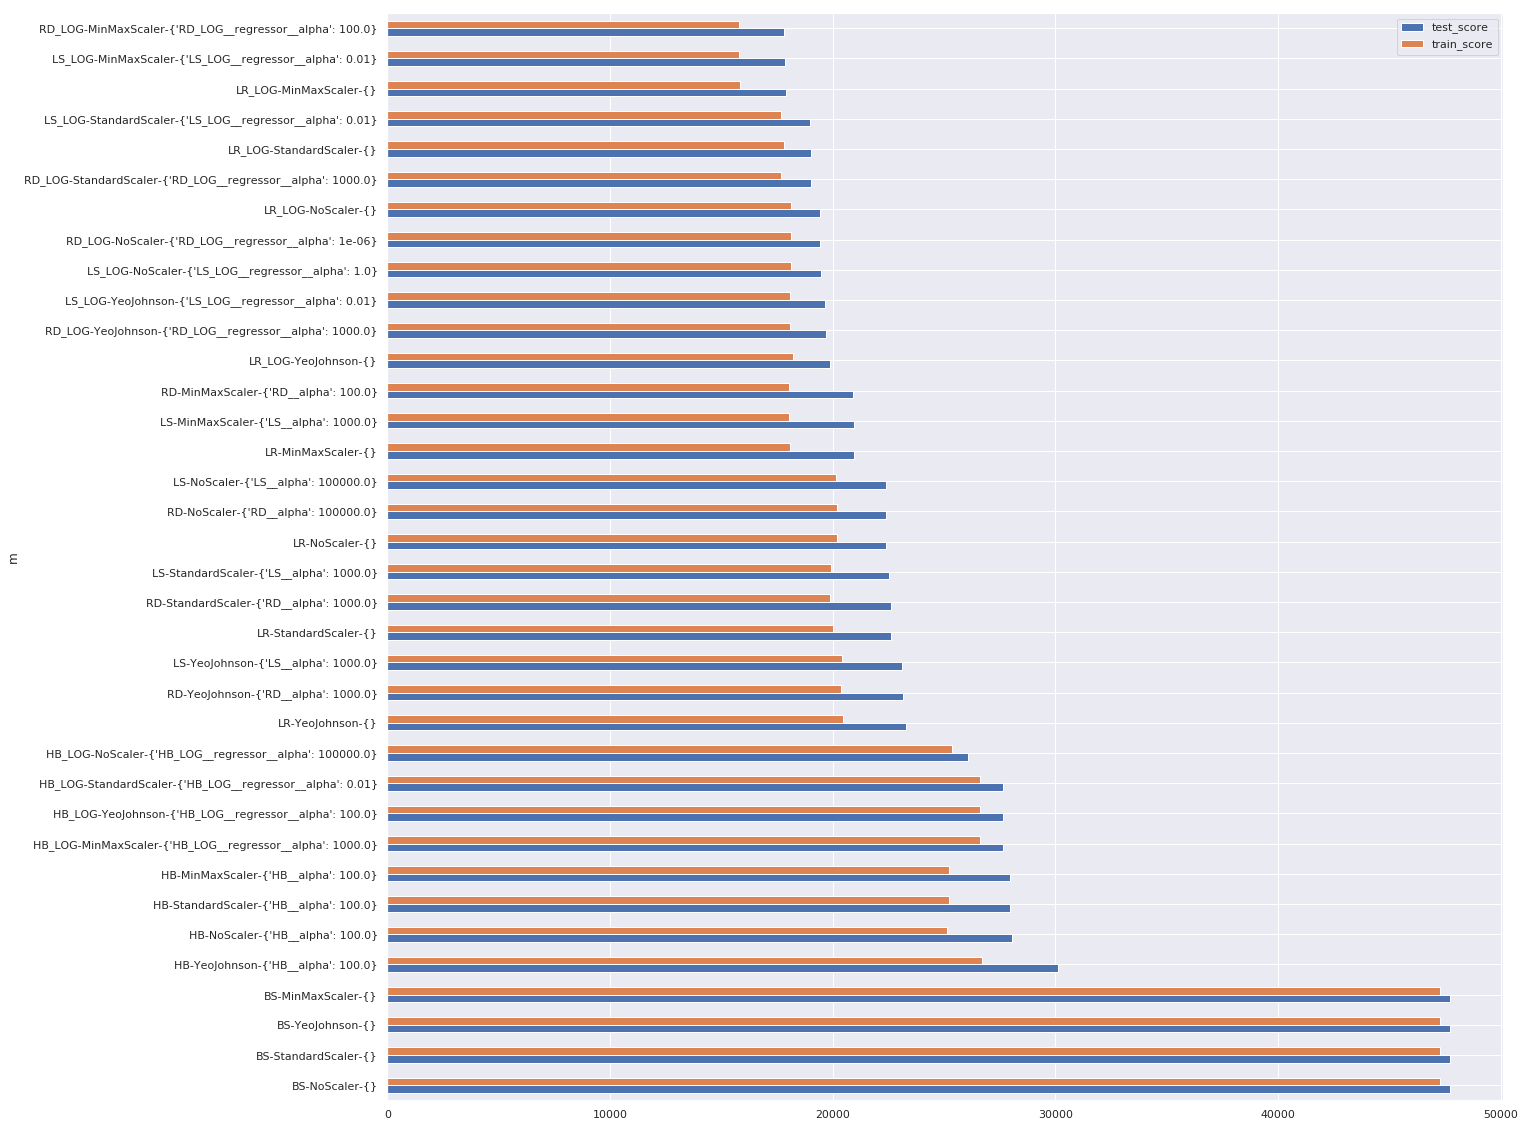

In [57]:
def get_pipeline(model, scaler, parameters=parameters,cols=None):
    if cols == None:
        num_cols = all_num_cols
        cat_cols = all_cat_cols
    else:
        num_cols = list(set(cols).intersection(set(all_num_cols)))
        cat_cols = list(set(cols).intersection(set(all_cat_cols)))
    pandas_transformer = PandasTransformer(transformData,cols)
    scale_transformer = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols) ,(scaler[0],  scaler[1], num_cols) ], remainder='passthrough')
    return Pipeline(steps=
                                     [('pandas',pandas_transformer),
                                      (scaler[0], scale_transformer),
                                      ('pca', TruncatedSVD(n_components=10)),
                                       model
                                     ]
                              )
results_intermediate_model_pca = get_models_results(cols=None)
results_intermediate_model_pca

In [58]:
print('Best intermediate model usng PCA:')
results_intermediate_model_pca.head(1)

Best intermediate model usng PCA:


model        scaler  \
m                                                                          
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  RD_LOG  MinMaxScaler   

                                                                            best_params  \
m                                                                                         
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  {'RD_LOG__regressor__alpha': 100.0}   

                                                    best_train_score_mean  \
m                                                                           
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...           16000.722402   

                                                    best_train_score_std  \
m                                                                          
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...             832.30093   

                                                     train_score    test_score  
m                                                                               
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  15790.255276  17838.228867

As we can see, using PCA gives almost same performance as selectKbest.

## Complex model

model: BS scaler: NoScaler
model: LR scaler: NoScaler
model: HB scaler: NoScaler
model: RD scaler: NoScaler
model: LS scaler: NoScaler
model: LR_LOG scaler: NoScaler
model: HB_LOG scaler: NoScaler
model: RD_LOG scaler: NoScaler
model: LR scaler: StandardScaler
model: LS_LOG scaler: NoScaler
model: BS scaler: StandardScaler
model: HB scaler: StandardScaler
model: RD scaler: StandardScaler
model: LS scaler: StandardScaler
model: LR_LOG scaler: StandardScaler
model: HB_LOG scaler: StandardScaler
model: RD_LOG scaler: StandardScaler
model: LS_LOG scaler: StandardScaler
model: BS scaler: MinMaxScaler
model: LR scaler: MinMaxScaler
model: LS scaler: MinMaxScaler
model: HB scaler: MinMaxScaler
model: LR_LOG scaler: MinMaxScaler
model: RD scaler: MinMaxScaler
model: HB_LOG scaler: MinMaxScaler
model: RD_LOG scaler: MinMaxScaler
model: LS_LOG scaler: MinMaxScaler
model: LR scaler: YeoJohnson
model: BS scaler: YeoJohnson
model: LS scaler: YeoJohnson
model: LR_LOG scaler: YeoJohnson
model: RD sca

model          scaler  \
m                                                                            
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....  LS_LOG        NoScaler   
LS_LOG-StandardScaler-{'LS_LOG__regressor__alph...  LS_LOG  StandardScaler   
LS_LOG-MinMaxScaler-{'LS_LOG__regressor__alpha'...  LS_LOG    MinMaxScaler   
LS_LOG-YeoJohnson-{'LS_LOG__regressor__alpha': ...  LS_LOG      YeoJohnson   
LR_LOG-StandardScaler-{}                            LR_LOG  StandardScaler   
LR_LOG-YeoJohnson-{}                                LR_LOG      YeoJohnson   
LS-NoScaler-{'LS__alpha': 100.0}                        LS        NoScaler   
LS-StandardScaler-{'LS__alpha': 100.0}                  LS  StandardScaler   
LS-MinMaxScaler-{'LS__alpha': 100.0}                    LS    MinMaxScaler   
LR_LOG-MinMaxScaler-{}                              LR_LOG    MinMaxScaler   
LS-YeoJohnson-{'LS__alpha': 100.0}                      LS      YeoJohnson   
LR_LOG-NoScaler-{}                                  LR_LOG        NoScaler   
LR-MinMaxScaler-{}                                      LR    MinMaxScaler   
LR-StandardScaler-{}                                    LR  StandardScaler   
LR-YeoJohnson-{}                                        LR      YeoJohnson   
LR-NoScaler-{}                                          LR        NoScaler   
HB_LOG-NoScaler-{'HB_LOG__regressor__alpha': 10...  HB_LOG        NoScaler   
HB-NoScaler-{'HB__alpha': 100.0}                        HB        NoScaler   
HB_LOG-StandardScaler-{'HB_LOG__regressor__alph...  HB_LOG  StandardScaler   
HB_LOG-YeoJohnson-{'HB_LOG__regressor__alpha': ...  HB_LOG      YeoJohnson   
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  HB_LOG    MinMaxScaler   
HB-YeoJohnson-{'HB__alpha': 100.0}                      HB      YeoJohnson   
HB-MinMaxScaler-{'HB__alpha': 100.0}                    HB    MinMaxScaler   
HB-StandardScaler-{'HB__alpha': 1e-06}                  HB  StandardScaler   
RD_LOG-NoScaler-{'RD_LOG__regressor__alpha': 0....  RD_LOG        NoScaler   
RD-NoScaler-{'RD__alpha': 1000.0}                       RD        NoScaler   
RD_LOG-YeoJohnson-{'RD_LOG__regressor__alpha': ...  RD_LOG      YeoJohnson   
RD_LOG-StandardScaler-{'RD_LOG__regressor__alph...  RD_LOG  StandardScaler   
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  RD_LOG    MinMaxScaler   
RD-YeoJohnson-{'RD__alpha': 1e-05}                      RD      YeoJohnson   
RD-StandardScaler-{'RD__alpha': 1e-05}                  RD  StandardScaler   
RD-MinMaxScaler-{'RD__alpha': 1e-05}                    RD    MinMaxScaler   
BS-YeoJohnson-{}                                        BS      YeoJohnson   
BS-MinMaxScaler-{}                                      BS    MinMaxScaler   
BS-StandardScaler-{}                                    BS  StandardScaler   
BS-NoScaler-{}                                          BS        NoScaler   

                                                                               best_params  \
m                                                                                            
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....    {'LS_LOG__regressor__alpha': 0.0001}   
LS_LOG-StandardScaler-{'LS_LOG__regressor__alph...    {'LS_LOG__regressor__alpha': 0.0001}   
LS_LOG-MinMaxScaler-{'LS_LOG__regressor__alpha'...    {'LS_LOG__regressor__alpha': 0.0001}   
LS_LOG-YeoJohnson-{'LS_LOG__regressor__alpha': ...    {'LS_LOG__regressor__alpha': 0.0001}   
LR_LOG-StandardScaler-{}                                                                {}   
LR_LOG-YeoJohnson-{}                                                                    {}   
LS-NoScaler-{'LS__alpha': 100.0}                                      {'LS__alpha': 100.0}   
LS-StandardScaler-{'LS__alpha': 100.0}                                {'LS__alpha': 100.0}   
LS-MinMaxScaler-{'LS__alpha': 100.0}                                  {'LS__alpha': 100.0}   
LR_LOG-MinMaxScaler-{}                                

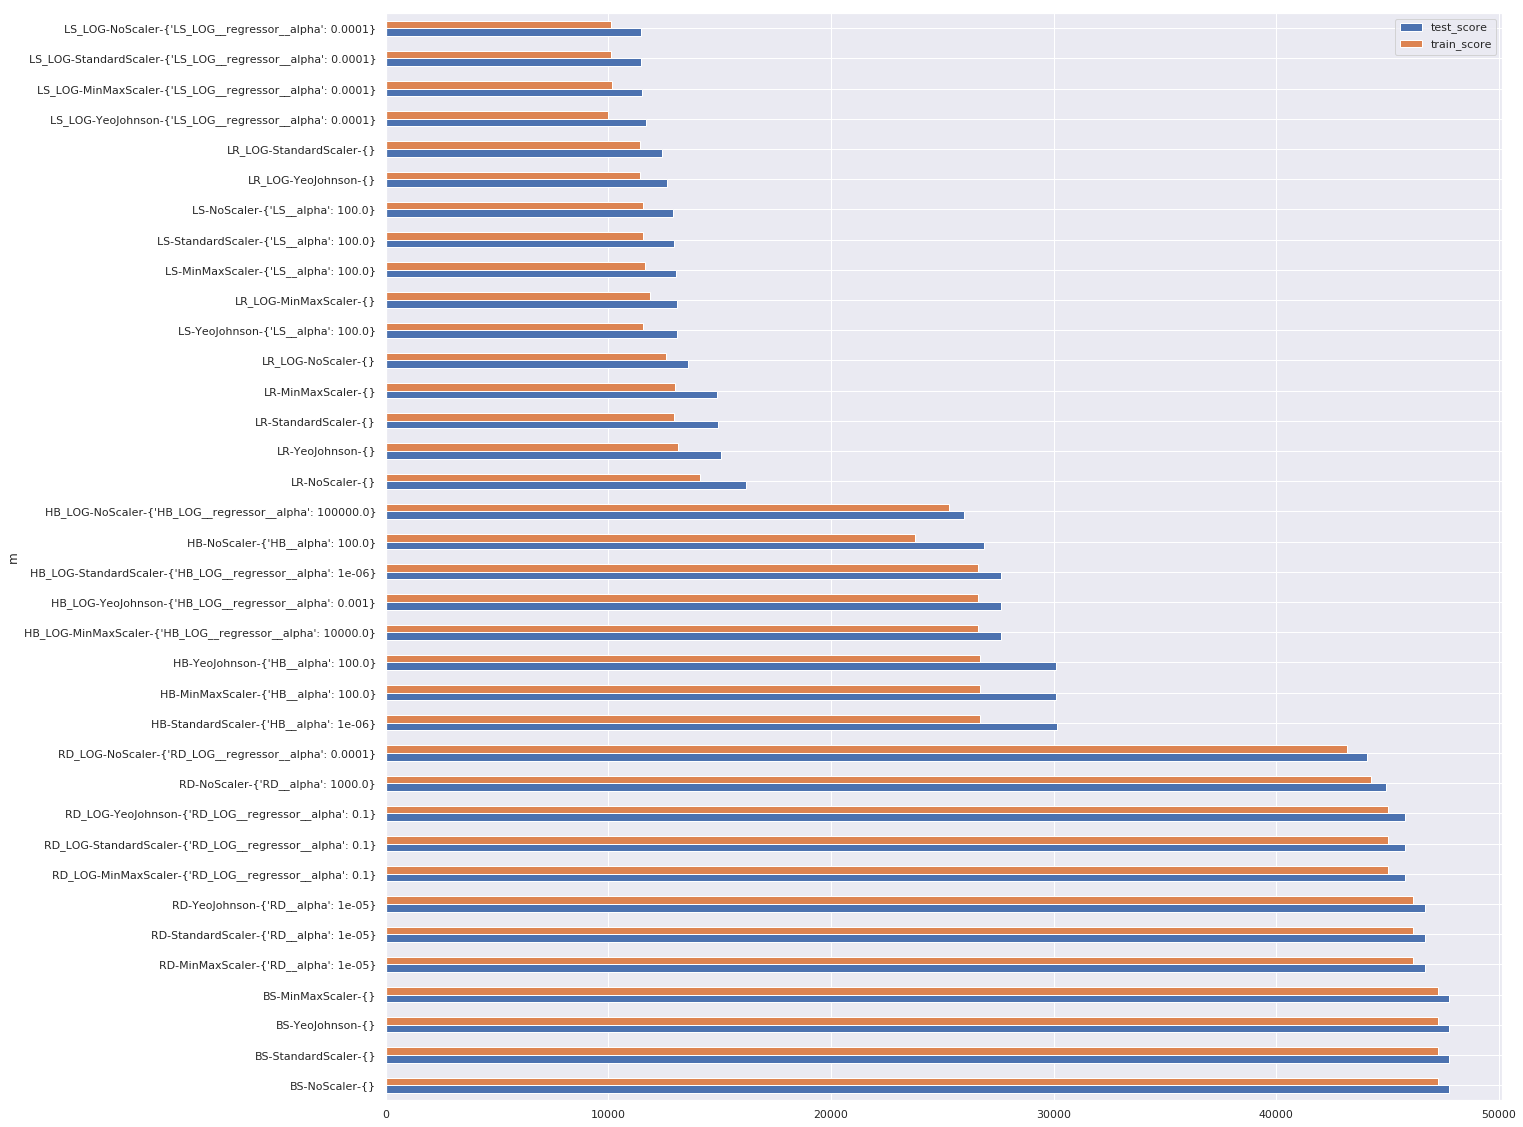

In [59]:
def get_pipeline(model, scaler, parameters=parameters,cols=None):
    if cols == None:
        num_cols = all_num_cols
        cat_cols = all_cat_cols
    else:
        num_cols = list(set(cols).intersection(set(all_num_cols)))
        cat_cols = list(set(cols).intersection(set(all_cat_cols)))
    pandas_transformer = PandasTransformer(transformData,cols)
    scale_transformer = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols) ,(scaler[0],  scaler[1], num_cols) ], remainder='passthrough')
    return Pipeline(steps=
                                     [('pandas',pandas_transformer),
                                      (scaler[0], scale_transformer),
                                       model
                                     ]
                              )
results_complex_model = get_models_results()
results_complex_model

In [60]:
print('Best simple Model  :')
results_simple_model.head(1)

Best simple Model  :


model        scaler  \
m                                                                          
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  HB_LOG  MinMaxScaler   

                                                                           best_params  \
m                                                                                        
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  {'HB_LOG__regressor__alpha': 10.0}   

                                                    best_train_score_mean  \
m                                                                           
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...           19868.294739   

                                                    best_train_score_std  \
m                                                                          
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...            888.819835   

                                                     train_score    test_score  
m                                                                               
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  19739.549646  20936.409869

In [61]:
print('Best intermediate model :')
results_intermediate_model.head(1)

Best intermediate model :


model    scaler  \
m                                                                      
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  LS_LOG  NoScaler   

                                                                            best_params  \
m                                                                                         
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  {'LS_LOG__regressor__alpha': 1e-06}   

                                                    best_train_score_mean  \
m                                                                           
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...           16458.126464   

                                                    best_train_score_std  \
m                                                                          
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...            903.522431   

                                                     train_score    test_score  
m                                                                               
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  16251.288228  17482.145453

In [62]:
print('Best intermediate model PCA :')
results_intermediate_model_pca.head(1)

Best intermediate model PCA :


model        scaler  \
m                                                                          
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  RD_LOG  MinMaxScaler   

                                                                            best_params  \
m                                                                                         
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  {'RD_LOG__regressor__alpha': 100.0}   

                                                    best_train_score_mean  \
m                                                                           
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...           16000.722402   

                                                    best_train_score_std  \
m                                                                          
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...             832.30093   

                                                     train_score    test_score  
m                                                                               
RD_LOG-MinMaxScaler-{'RD_LOG__regressor__alpha'...  15790.255276  17838.228867

In [63]:
print('Best complex model :')
results_complex_model.head(1)

Best complex model :


model    scaler  \
m                                                                      
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....  LS_LOG  NoScaler   

                                                                             best_params  \
m                                                                                          
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....  {'LS_LOG__regressor__alpha': 0.0001}   

                                                    best_train_score_mean  \
m                                                                           
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....           11878.627873   

                                                    best_train_score_std  \
m                                                                          
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....            661.400068   

                                                     train_score    test_score  
m                                                                               
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....  10100.473506  11449.451759

The complex model gives the best performance. **MAE** goes down to **11449 dollars**

The learning curve of the best model is the following :

model: LS_LOG scaler: NoScaler


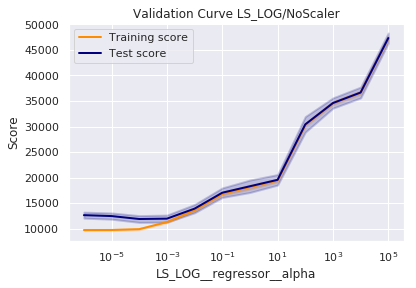

In [64]:
plot_validation_curve(models[8], scalers[0]);

This validation curve shows that the best parameter for test score is $alpha=10^{-4}$

## Conclusions

### model comparaison

The following chart gives performance results for each model :


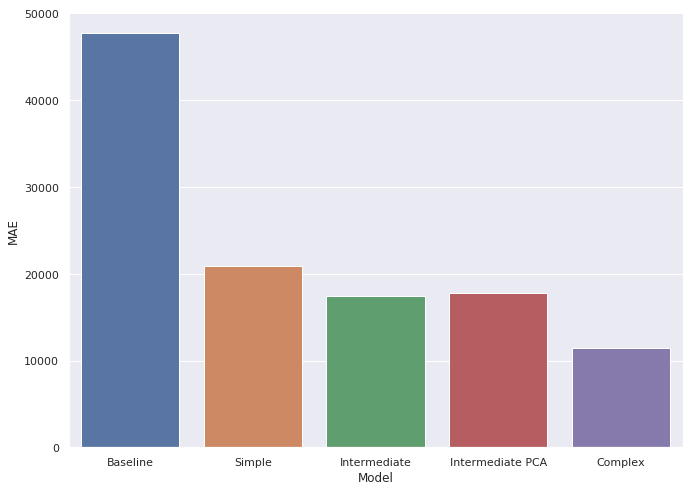

In [65]:
df = pd.DataFrame({"Model":['Baseline','Simple', 'Intermediate', 'Intermediate PCA', 'Complex'],
                   "MAE":[  results_complex_model.loc['BS-NoScaler-{}'].test_score,
                            results_simple_model.iloc[0].test_score,
                            results_intermediate_model.iloc[0].test_score,
                            results_intermediate_model_pca.iloc[0].test_score,
                            results_complex_model.iloc[0].test_score]
                    })
sns.set(rc={'figure.figsize':(11,8)})
sns.barplot(x="Model", y="MAE", data=df);

We observe also that Lasso gives better performance when we include many features in our dataset (intermediate and complex model). This can be explained by the fact that it do automatic feature selection.

This algorithms give better performance whithout any scaling.

## Compute predictions

Make predictions for the 500 new houses from house-prices-test.csv using each model and save them in a .csv file.

#### Simple model

We will refit the model with the hole dataset, then, gererate predictions for test dataset.

In [66]:
X_data = data[data.columns.difference(['SalePrice'])]
y_data = data['SalePrice']
X_testset = test
results_simple_model.head(1)

model        scaler  \
m                                                                          
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  HB_LOG  MinMaxScaler   

                                                                           best_params  \
m                                                                                        
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  {'HB_LOG__regressor__alpha': 10.0}   

                                                    best_train_score_mean  \
m                                                                           
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...           19868.294739   

                                                    best_train_score_std  \
m                                                                          
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...            888.819835   

                                                     train_score    test_score  
m                                                                               
HB_LOG-MinMaxScaler-{'HB_LOG__regressor__alpha'...  19739.549646  20936.409869

In [67]:
run_one_model(models[6], scalers[2],cols=['FE_totalSF','Garage Cars','Bsmt Qual'], parameters=parameters)

model: HB_LOG scaler: MinMaxScaler


('HB_LOG',
 'MinMaxScaler',
 "{'HB_LOG__regressor__alpha': 10.0}",
 19868.294739062534,
 888.8198351335731,
 19739.549645988176,
 20936.409868632425)

In [68]:
clf = get_cv(models[6], scalers[2],cols=['FE_totalSF','Garage Cars','Bsmt Qual'], parameters=parameters)
clf.best_estimator_.fit(X_data,y_data)
y_testset = clf.best_estimator_.predict(X_testset)
df = pd.DataFrame({'PID':X_testset.PID, 'SalePrice':y_testset.round().astype(np.int64)})
df.to_csv('predictions-simple-model.csv',index=False)

model: HB_LOG scaler: MinMaxScaler


#### Intermediate model

In [69]:
results_intermediate_model.head(1)

model    scaler  \
m                                                                      
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  LS_LOG  NoScaler   

                                                                            best_params  \
m                                                                                         
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  {'LS_LOG__regressor__alpha': 1e-06}   

                                                    best_train_score_mean  \
m                                                                           
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...           16458.126464   

                                                    best_train_score_std  \
m                                                                          
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...            903.522431   

                                                     train_score    test_score  
m                                                                               
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 1e...  16251.288228  17482.145453

In [70]:
run_one_model(models[8], scalers[0],cols=selected_features_df.sort_values(by='Scores', ascending=False)[:10].Feature.to_list(), parameters=parameters)

model: LS_LOG scaler: NoScaler


('LS_LOG',
 'NoScaler',
 "{'LS_LOG__regressor__alpha': 1e-06}",
 16458.12646392905,
 903.5224305183694,
 16251.288227671579,
 17482.145453177585)

In [71]:
clf = get_cv(models[8], scalers[0],cols=selected_features_df.sort_values(by='Scores', ascending=False)[:10].Feature.to_list(), parameters=parameters)
clf.best_estimator_.fit(X_data,y_data)
y_testset = clf.best_estimator_.predict(X_testset)
df = pd.DataFrame({'PID':X_testset.PID, 'SalePrice':y_testset.round().astype(np.int64)})
df.to_csv('predictions-intermediate-model.csv',index=False)

model: LS_LOG scaler: NoScaler


#### Complex model

In [72]:
results_complex_model.head(1)

model    scaler  \
m                                                                      
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....  LS_LOG  NoScaler   

                                                                             best_params  \
m                                                                                          
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....  {'LS_LOG__regressor__alpha': 0.0001}   

                                                    best_train_score_mean  \
m                                                                           
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....           11878.627873   

                                                    best_train_score_std  \
m                                                                          
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....            661.400068   

                                                     train_score    test_score  
m                                                                               
LS_LOG-NoScaler-{'LS_LOG__regressor__alpha': 0....  10100.473506  11449.451759

In [73]:
run_one_model(models[8], scalers[0], parameters=parameters)

model: LS_LOG scaler: NoScaler


('LS_LOG',
 'NoScaler',
 "{'LS_LOG__regressor__alpha': 0.0001}",
 11878.627872677447,
 661.4000677366766,
 10100.473506460305,
 11449.451759322115)

In [74]:
clf = get_cv(models[8], scalers[0], parameters=parameters)
clf.best_estimator_.fit(X_data,y_data)
y_testset = clf.best_estimator_.predict(X_testset)
df = pd.DataFrame({'PID':X_testset.PID, 'SalePrice':y_testset.round().astype(np.int64)})
df.to_csv('predictions-complex-model.csv',index=False)

model: LS_LOG scaler: NoScaler
